In [1]:
import fsps
import matplotlib.pyplot as plt
import numpy as np
from spec_exam import F_lam_per_M
from glob import glob
from scipy.interpolate import interp1d
import matplotlib.gridspec as gridspec
import seaborn as sea
import pandas as pd
from spec_exam import Gen_spec_2D
from make_sfh_tool import Gen_sim_SFH
import pickle
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)


Couldn't `import tristars`.  Get it from https://github.com/gbrammer/tristars to enable improved blind astrometric matching with triangle asterisms.



In [2]:
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)

In [232]:
lbt, sfh = np.load('../sim_SFH/SFH_z2.0_0.npy',allow_pickle = True)
sfh = sfh[1:]
lbt = lbt[:-1]

In [233]:
sp.set_tabular_sfh(lbt, sfh[::-1])
sp.params['dust2'] = 0.0
sp.params['dust1'] = 0.0
sp.params['logzsol'] = np.log10(1)

wave, flux = sp.get_spectrum(tage = lbt[-1], peraa = True)
flam = F_lam_per_M(flux,wave*(1+1.5),1.5,0,sp.stellar_mass)*10**11


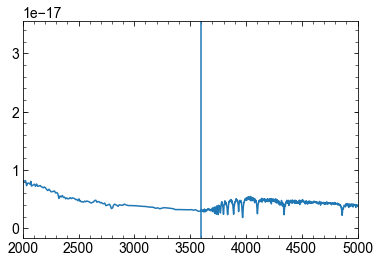

In [234]:
plt.plot(wave,flam)
plt.xlim(2000, 5000)
plt.axvline(3600)
# plt.xscale('log')

In [91]:
def get_sSFR(lbt, sfh, lmass = 11):
    lbtX = np.linspace(0,0.1)
    isfh = interp1d(lbt, sfh)(lbtX)
    SFR = np.trapz(isfh, lbtX*10**9)/10**8
    sSFR = np.log10(SFR/10**lmass)                 ### log value
    return SFR, sSFR 

array([0.21476927, 0.21409287, 0.2225211 , 0.19302003, 0.19659132,
       0.20622805, 0.24366648, 0.22344954, 0.2069277 , 0.19244868,
       0.19651709, 0.2021647 , 0.24818934, 0.24917151, 0.22304075,
       0.28936578, 0.45007794, 0.46235915, 0.4895831 , 0.5747094 ,
       0.60844513, 0.62498765, 0.61876357, 0.60343541, 0.59212328,
       0.63606049, 0.65762492, 0.6384323 , 0.61854091, 0.61615724,
       0.61196633, 0.63310305, 0.6118286 , 0.59672038, 0.64841866,
       0.64305097, 0.61608009, 0.5721184 , 0.4442295 , 0.38560348,
       0.35355192, 0.36159852, 0.29756672, 0.31690987, 0.28950288,
       0.3011239 , 0.28554069, 0.28638691, 0.28439253, 0.3193382 ,
       0.38782143, 0.35816948, 0.35547117, 0.44966303, 0.51268766,
       0.59527309, 0.57975262, 0.44430028, 0.68431343, 1.3688238 ,
       0.96586361, 0.88340472, 0.83006319, 0.51706841, 0.33616239,
       0.28882467, 0.29853405, 0.28169829, 0.28220524, 0.26681094,
       0.24014786, 0.20761721, 0.17267644, 0.15275959, 0.14718

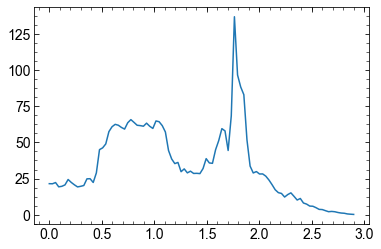

In [236]:

plt.plot(lbt, sfh*10**2)
# plt.ylim(0,10)
# plt.axvline(0.1)
sfh

In [81]:
sfhlist = glob('../sim_SFH/SFH_z1.0_*')

def get_timescales(lbt,sfh):
    T=[0]
    M=[0]
    
    for ii in range(len(lbt)-1):
        mass = sfh[ii+1] * (lbt[ii+1] - lbt[ii])
        M.append(M[ii] + mass)
        T.append(lbt[ii+1])

    t50 = interp1d(M/ M[-1], T)(0.5)
    t90 = interp1d(M/ M[-1], T)(0.1)    
    tq = t50 -t90
    return t50, t90, tq

In [59]:
from spec_id import Gaussian_prior, log_10_prior
    
def Z_prior_mu(lmass):
    M = [7,9, 11.5,13]
    P = [-0.5813,-0.5813, 0.06818,0.06818]
    iP = interp1d(M,P)
    return iP(lmass) 

onesig = (0.04 + 0.47)/2
mllim = np.log10(0.001 / 0.019)
mhlim = np.log10(0.031 / 0.019)

In [116]:
zdb1 = pd.read_pickle('../dataframes/galaxy_frames/sim_z1.0.pkl')

i = 0
lbt, sfh = np.load('../sim_SFH/SFH_z1.0_{}.npy'.format(i),allow_pickle = True)
lbt = lbt - min(lbt)

# # randomly select dust
dust = np.random.choice(np.linspace(0,1.5,100))
metallicity = 1.5
sp.set_tabular_sfh(lbt, sfh[::-1])
sp.params['dust2'] = dust
sp.params['dust1'] = dust
sp.params['logzsol'] = np.log10(metallicity)

sp.params['compute_light_ages'] = False
wave,flux = sp.get_spectrum(tage = lbt[-1], peraa=True)
lmass = np.log10(sp.stellar_mass)
LMASS.append(lmass)

# randomly select metallicity
metallicity = 10**Gaussian_prior(np.random.rand(), [mllim, mhlim], Z_prior_mu(lmass), onesig)

sp.set_tabular_sfh(lbt, sfh[::-1])
sp.params['dust2'] = dust
sp.params['dust1'] = dust
sp.params['logzsol'] = np.log10(metallicity)

sp.params['compute_light_ages'] = True
lwa = sp.get_mags(tage = lbt[-1], bands=['sdss_g'])[0]
LWA.append(lwa)

sfr, ssfr = get_sSFR(lbt, sfh, lmass = lmass)
if not ssfr > -100:
    ssfr = -15
SFR.append(sfr)
sSFR.append(ssfr)   
t50, t90, tq = get_timescales(lbt,sfh)
T50.append(t50)
T90.append(t90)
TQ.append(tq)
Z.append(metallicity)
AV.append(dust)
RSHIFT.append(1.0)
if lwa > 1.7:
    SFA.append('Q')
else:
    SFA.append('S')
GID.append(i)
  
    
### keep original mass, sfr, ssfr, t50, t90, tq    

In [132]:
flam = F_lam_per_M(flux,wave*(1+1),1,0,10**lmass)*10**lmass

(1000, 8000)

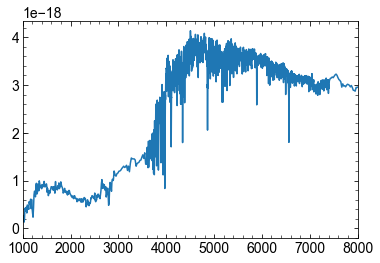

In [134]:
plt.plot(wave,flam)
plt.xlim(1000,8000)

In [104]:
print(sfr, ssfr)
print(zdb1.sfr[i], zdb1.sSFR[i])

5.070972046443125 -10.24372604891139
5.05418779736904 -10.42252678656692


(2000, 8000)

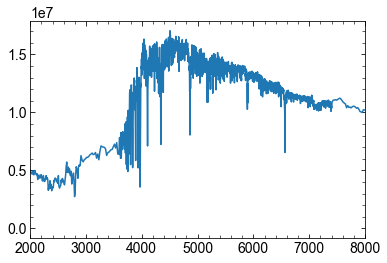

In [78]:
plt.plot(wave,flux)
plt.xlim(2000,8000)

In [135]:
SFR = []
SFA = []
sSFR = []
LWA = []
MAX_AGE = []
T50 = []
T90 = []
TQ = []
Z = []
LMASS = []
AV = []
RSHIFT = []
GID = []

OMASS = [] 
OSFR=[] 
OSSFR=[] 
OT50=[] 
OT90 = []
OTQ = []    

zdb1 = pd.read_pickle('../dataframes/galaxy_frames/sim_z1.0.pkl')

sfhlist = glob('../sim_SFH/SFH_z1.0_*')
for i in range(len(sfhlist)):
    lbt, sfh = np.load('../sim_SFH/SFH_z1.0_{}.npy'.format(i),allow_pickle = True)
    lbt = lbt - min(lbt)

    # # randomly select dust
    dust = np.random.choice(np.linspace(0,1.5,100))
    metallicity = 1.
    sp.set_tabular_sfh(lbt, sfh[::-1])
    sp.params['dust2'] = dust
    sp.params['dust1'] = dust
    sp.params['logzsol'] = np.log10(metallicity)

    sp.params['compute_light_ages'] = False
    wave,flux = sp.get_spectrum(tage = lbt[-1], peraa=True)
    lmass = np.log10(sp.stellar_mass)
    LMASS.append(lmass)

    # randomly select metallicity
    metallicity = 10**Gaussian_prior(np.random.rand(), [mllim, mhlim], Z_prior_mu(lmass), onesig)

    sp.set_tabular_sfh(lbt, sfh[::-1])
    sp.params['dust2'] = dust
    sp.params['dust1'] = dust
    sp.params['logzsol'] = np.log10(metallicity)

    sp.params['compute_light_ages'] = True
    lwa = sp.get_mags(tage = lbt[-1], bands=['sdss_g'])[0]
    LWA.append(lwa)

    sfr, ssfr = get_sSFR(lbt, sfh, lmass = lmass)
    if not ssfr > -100:
        ssfr = -15
    SFR.append(sfr)
    sSFR.append(ssfr)   
    t50, t90, tq = get_timescales(lbt,sfh)
    T50.append(t50)
    T90.append(t90)
    TQ.append(tq)
    Z.append(metallicity)
    AV.append(dust)
    RSHIFT.append(1.0)
    if lwa > 1.7:
        SFA.append('Q')
    else:
        SFA.append('S')
    GID.append(i)
    OMASS.append(zdb1.lmass[i])
    OSFR.append(zdb1.sfr[i])
    OSSFR.append(zdb1.sSFR[i])
    OT50.append(zdb1.t50[i])
    OT90.append(zdb1.t90[i])
    OTQ.append(zdb1.tq[i])

  
zdb1 = pd.read_pickle('../dataframes/galaxy_frames/sim_z1.5.pkl')

sfhlist = glob('../sim_SFH/SFH_z1.5_*')
for i in range(len(sfhlist)):
    lbt, sfh = np.load('../sim_SFH/SFH_z1.5_{}.npy'.format(i),allow_pickle = True)
    lbt = lbt - min(lbt)

    # # randomly select dust
    dust = np.random.choice(np.linspace(0,1.5,100))
    metallicity = 1.
    sp.set_tabular_sfh(lbt, sfh[::-1])
    sp.params['dust2'] = dust
    sp.params['dust1'] = dust
    sp.params['logzsol'] = np.log10(metallicity)

    sp.params['compute_light_ages'] = False
    wave,flux = sp.get_spectrum(tage = lbt[-1], peraa=True)
    lmass = np.log10(sp.stellar_mass)
    LMASS.append(lmass)

    # randomly select metallicity
    metallicity = 10**Gaussian_prior(np.random.rand(), [mllim, mhlim], Z_prior_mu(lmass), onesig)

    sp.set_tabular_sfh(lbt, sfh[::-1])
    sp.params['dust2'] = dust
    sp.params['dust1'] = dust
    sp.params['logzsol'] = np.log10(metallicity)

    sp.params['compute_light_ages'] = True
    lwa = sp.get_mags(tage = lbt[-1], bands=['sdss_g'])[0]
    LWA.append(lwa)

    sfr, ssfr = get_sSFR(lbt, sfh, lmass = lmass)
    if not ssfr > -100:
        ssfr = -15
    SFR.append(sfr)
    sSFR.append(ssfr)   
    t50, t90, tq = get_timescales(lbt,sfh)
    T50.append(t50)
    T90.append(t90)
    TQ.append(tq)
    Z.append(metallicity)
    AV.append(dust)
    RSHIFT.append(1.5)
    if lwa > 1.1:
        SFA.append('Q')
    else:
        SFA.append('S')
    GID.append(i)
    OMASS.append(zdb1.lmass[i])
    OSFR.append(zdb1.sfr[i])
    OSSFR.append(zdb1.sSFR[i])
    OT50.append(zdb1.t50[i])
    OT90.append(zdb1.t90[i])
    OTQ.append(zdb1.tq[i])
 
zdb1 = pd.read_pickle('../dataframes/galaxy_frames/sim_z2.0.pkl')

sfhlist = glob('../sim_SFH/SFH_z2.0_*')
for i in range(len(sfhlist)):
    lbt, sfh = np.load('../sim_SFH/SFH_z2.0_{}.npy'.format(i),allow_pickle = True)
    lbt = lbt - min(lbt)

    # # randomly select dust
    dust = np.random.choice(np.linspace(0,1.5,100))
    metallicity = 1.
    sp.set_tabular_sfh(lbt, sfh[::-1])
    sp.params['dust2'] = dust
    sp.params['dust1'] = dust
    sp.params['logzsol'] = np.log10(metallicity)

    sp.params['compute_light_ages'] = False
    wave,flux = sp.get_spectrum(tage = lbt[-1], peraa=True)
    lmass = np.log10(sp.stellar_mass)
    LMASS.append(lmass)

    # randomly select metallicity
    metallicity = 10**Gaussian_prior(np.random.rand(), [mllim, mhlim], Z_prior_mu(lmass), onesig)

    sp.set_tabular_sfh(lbt, sfh[::-1])
    sp.params['dust2'] = dust
    sp.params['dust1'] = dust
    sp.params['logzsol'] = np.log10(metallicity)

    sp.params['compute_light_ages'] = True
    lwa = sp.get_mags(tage = lbt[-1], bands=['sdss_g'])[0]
    LWA.append(lwa)

    sfr, ssfr = get_sSFR(lbt, sfh, lmass = lmass)
    if not ssfr > -100:
        ssfr = -15
    SFR.append(sfr)
    sSFR.append(ssfr)   
    t50, t90, tq = get_timescales(lbt,sfh)
    T50.append(t50)
    T90.append(t90)
    TQ.append(tq)
    Z.append(metallicity)
    AV.append(dust)
    RSHIFT.append(2.0)
    if lwa > 0.7:
        SFA.append('Q')
    else:
        SFA.append('S')
    GID.append(i)
    OMASS.append(zdb1.lmass[i])
    OSFR.append(zdb1.sfr[i])
    OSSFR.append(zdb1.sSFR[i])
    OT50.append(zdb1.t50[i])
    OT90.append(zdb1.t90[i])
    OTQ.append(zdb1.tq[i])

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


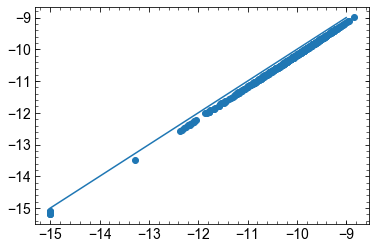

In [139]:
plt.scatter(sSFR, OSSFR)
plt.plot([-15, -9],[-15, -9])

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


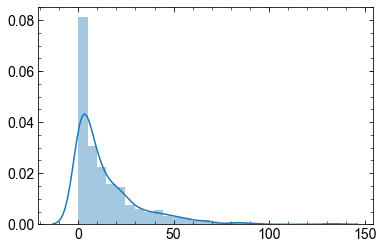

In [136]:
sea.distplot(SFR)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


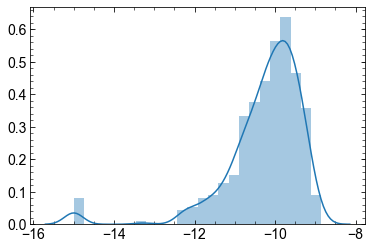

In [107]:
sea.distplot(np.array(sSFR))

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


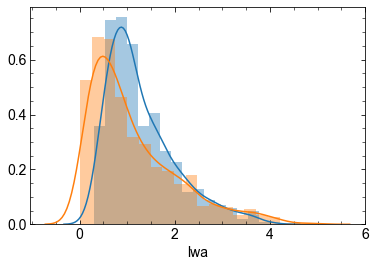

In [110]:
sea.distplot(np.array(LWA))
sea.distplot(Adb.lwa)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


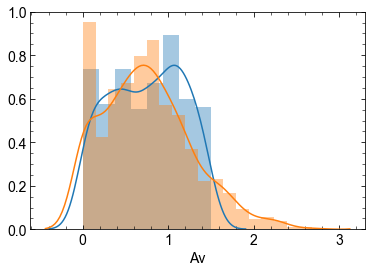

In [111]:
sea.distplot(np.array(AV))
sea.distplot(Adb.Av)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


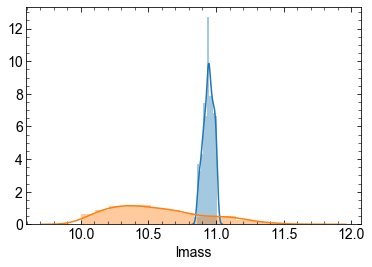

In [112]:
sea.distplot(np.array(LMASS))
sea.distplot(Adb.lmass)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


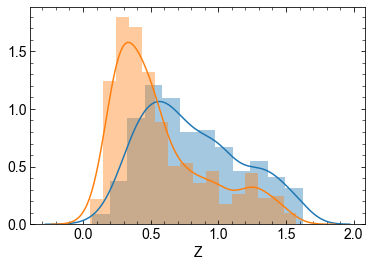

In [113]:
sea.distplot(np.array(Z))
sea.distplot(Adb.Z)

In [109]:
adb = pd.read_pickle('../dataframes/fitdb/evolution_db.pkl')
Adb = adb.query('AGN != "AGN" and lmass > 10 and concen < -0.4 and 0.7 < zgrism < 2.7')

In [140]:
Sdb = pd.DataFrame({'lwa' : LWA, 'sfr' : SFR, 'sSFR' : sSFR, 't50':T50, 't90':T90, 'tq':TQ, 
                    'SFa' : SFA, 'Z':Z, 'lmass':LMASS, 'Av':AV, 'zgrism':RSHIFT, 'gid': GID,
                   'omass' : OMASS,'osfr' : OSFR,'osSFR' : OSSFR,'ot50' : OT50,'ot90' : OT90,'otq' : OTQ})

In [141]:
Sdb.to_pickle('../dataframes/galaxy_frames/Illustris_sim_v2.pkl')


(0, 3)

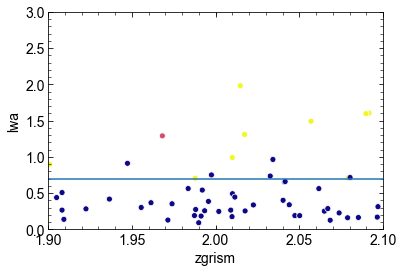

In [302]:
sea.scatterplot(Adb.zgrism, Adb.lwa, hue=Adb.sf_prob_2, legend=False, palette = 'plasma_r')

plt.xlim(1.9,2.1)
plt.axhline(0.7)
plt.ylim(0,3)
#z1.0 - 1.7
#z1.5 - 1.1
#z2.0 - 0.7

In [224]:
sp.params['compute_light_ages'] = False

In [365]:
from spec_id import Gather_grism_data_from_2d, Full_forward_model, Scale_model
def spec_sim_werr(Gs,lbt,sfh, dust, metal, SFa, lm = 11, z = 1.5):
    wvs, flxs, errs, beams, trans = Gather_grism_data_from_2d(Gs, sp)
    sp.set_tabular_sfh(lbt, sfh[::-1])
    sp.params['dust2'] = dust
    
    if SFa == 'Q':
        sp.params['dust1'] = dust
    else:
        sp.params['dust1'] = 0
        
    sp.params['logzsol'] = np.log10(metal)

    wave, flux = sp.get_spectrum(tage = lbt[-1], peraa = True)
    flam = F_lam_per_M(flux,wave*(1+z),z,0,10**lm)*10**lm

    Smfl, Pmfl = Full_forward_model(Gs, wave, F_lam_per_M(flux,wave*(1 + z), z, 0, sp.stellar_mass)*10**lm, z, 
                                    wvs, flxs, errs, beams, trans)
    
    Sc =  Scale_model(Gs.Pflx, Gs.Perr, Pmfl)
    
    for i in range(len(Smfl)):
        Smfl[i] = Smfl[i] + np.random.normal(0,errs[i])/Sc
        Pmfl[i] = Pmfl[i] + np.random.normal(0,Gs.Perr[i])/Sc
    
    return wvs, Smfl, errs/Sc, beams, trans, Pmfl, Gs.Perr/Sc


S


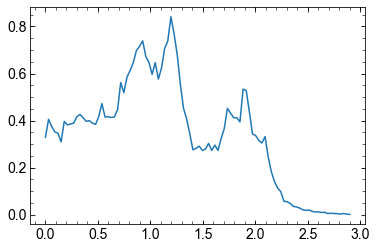

In [426]:
gal =309
lbt, sfh = np.load('../sim_SFH/SFH_z{}_{}.npy'.format(Sdb.zgrism[gal],Sdb.gid[gal]),allow_pickle = True)
sfh = sfh[1:]
lbt = lbt[:-1]
SFa = Sdb.SFa[gal]
rshift = Sdb.zgrism[gal]
dust = Sdb.Av[gal]
metal = Sdb.Z[gal]
lmass = Sdb.lmass[gal]
print(SFa)
plt.plot(lbt,sfh)

In [427]:
if SFa == 'Q':
    sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)
    Gs = Gen_spec_2D('GND', 21156, rshift, g102_lims=[8200, 11300], g141_lims=[11200, 16000],
                 phot_errterm = 0.04, irac_err = 0.08, mask = False)
else:
    sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 2)
    if rshift == 1.0:
        #maybe 16041
        Gs = Gen_spec_2D('GND',37006, 1.0, g102_lims=[8200, 11300], g141_lims=[11200, 16000],
             phot_errterm = 0.04, irac_err = 0.08, mask = True)
    if rshift == 1.5:
        Gs = Gen_spec_2D('GND',27930, 1.5, g102_lims=[8200, 11300], g141_lims=[11200, 16000],
                     phot_errterm = 0.04, irac_err = 0.08, mask = True)
    if rshift == 2.0:
        Gs = Gen_spec_2D('GND', 19591, 2.0, g102_lims=[8200, 11300], g141_lims=[11200, 16000],
             phot_errterm = 0.04, irac_err = 0.08, mask = True)

load_master_fits: /Volumes/Vince_CLEAR/RELEASE_v2.1.0/BEAMS/GN2/GN2_19591.beams.fits
1 icat08hiq_flt.fits G102
2 icat08hnq_flt.fits G102
3 icat08huq_flt.fits G102
4 icat08hzq_flt.fits G102
5 icxt55krq_flt.fits G102
6 icxt55ksq_flt.fits G102
7 icxt55kvq_flt.fits G102
8 icxt55kxq_flt.fits G102
9 icxta4mdq_flt.fits G102
10 icxta4meq_flt.fits G102
11 icxta4mhq_flt.fits G102
12 icxta4mjq_flt.fits G102
13 icxt52i0q_flt.fits G102
14 icxt52i1q_flt.fits G102
15 icxt52i4q_flt.fits G102
16 icxt52i6q_flt.fits G102
17 icxt53i9q_flt.fits G102
18 icxt53iaq_flt.fits G102
19 icxt53idq_flt.fits G102
20 icxt53ifq_flt.fits G102
21 icxt51jvq_flt.fits G102
22 icxt51jwq_flt.fits G102
23 icxt51jzq_flt.fits G102
24 icxt51k1q_flt.fits G102
25 ib3708i5q_flt.fits G141
26 ib3708i9q_flt.fits G141
27 ib3708ilq_flt.fits G141
28 ib3708ipq_flt.fits G141
29 ib3748v8q_flt.fits G141
30 ib3748vdq_flt.fits G141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-1.0.dev1443-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1585: RuntimeWarning: divide by zero encountered in true_divide
  ivar = 1./(1/b.ivar + (self.sys_err*sciu)**2)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/spec_exam.py:786: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bm.grism.parent_file in BMX:
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-1.0.dev1443-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:590: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


True
advanced
True
advanced


In [428]:
wvs, flxs, errs, beams, trans, Spmfl, Spmerr = spec_sim_werr(Gs, lbt, sfh, dust, metal, SFa, lm = lmass, z=rshift)

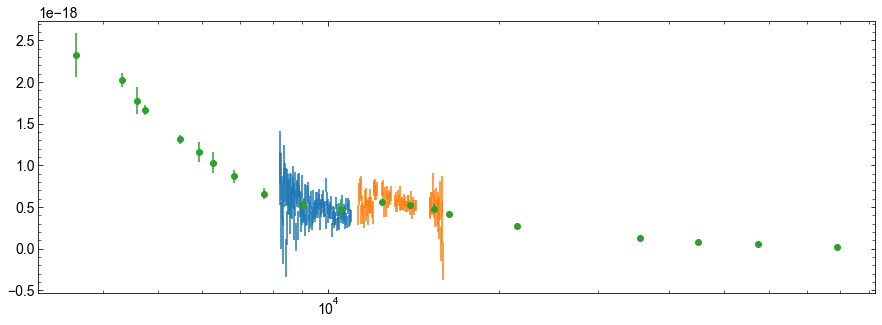

In [429]:
plt.figure(figsize = [15,5])
plt.errorbar(wvs[0],flxs[0],errs[0], linestyle = 'none')
plt.errorbar(wvs[1],flxs[1],errs[1], linestyle = 'none')
plt.errorbar(Gs.Pwv, Spmfl, Spmerr, fmt = 'o')
plt.xscale('log')
# plt.xlim(8000,15000)

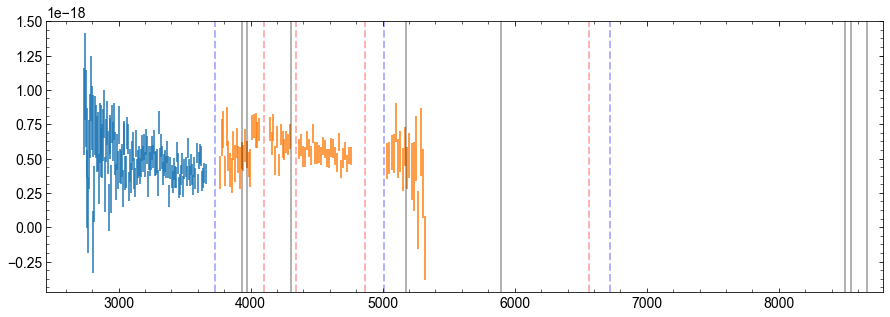

In [430]:
plt.figure(figsize = [15,5])
plt.errorbar(wvs[0]/(1+rshift),flxs[0],errs[0], linestyle = 'none')
plt.errorbar(wvs[1]/(1+rshift),flxs[1],errs[1], linestyle = 'none')
plt.axvline(3727.092 ,linestyle='--', alpha=0.3, color = 'b', linewidth = 2)
plt.axvline(5008.240,linestyle='--', alpha=0.3, color = 'b', linewidth = 2)
# Balmer
plt.axvline(4102.89 ,linestyle='--', alpha=0.3, color = 'r', linewidth = 2)
plt.axvline(4341.68 ,linestyle='--', alpha=0.3, color = 'r', linewidth = 2)
plt.axvline(4862.68 ,linestyle='--', alpha=0.3, color = 'r', linewidth = 2)
plt.axvline(6564.61 ,linestyle='--', alpha=0.3, color = 'r', linewidth = 2)

plt.axvline(6718.29,linestyle='--', alpha=0.3, color = 'b', linewidth = 2) #SII

plt.axvline(3934,linestyle='-', alpha=0.3, color = 'k', linewidth = 2) # H
plt.axvline(3969,linestyle='-', alpha=0.3, color = 'k', linewidth = 2) # K
plt.axvline(4305,linestyle='-', alpha=0.3, color = 'k', linewidth = 2) # G

plt.axvline(5176.7,linestyle='-', alpha=0.3, color = 'k', linewidth = 2) # Mg
plt.axvline(5895.6,linestyle='-', alpha=0.3, color = 'k', linewidth = 2) #Na
plt.axvline(8500,linestyle='-', alpha=0.3, color = 'k', linewidth = 2) #CaII
plt.axvline(8544,linestyle='-', alpha=0.3, color = 'k', linewidth = 2) #CaII
plt.axvline(8664,linestyle='-', alpha=0.3, color = 'k', linewidth = 2) #CaII

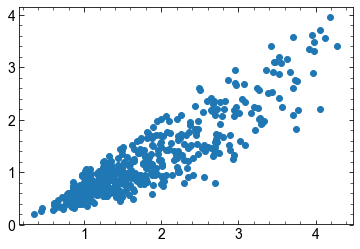

In [379]:
plt.scatter(Sdb.t50, Sdb.lwa)

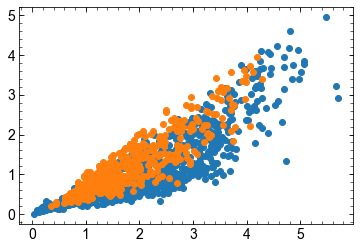

In [380]:
plt.scatter(Adb.t_50, Adb.lwa)
plt.scatter(Sdb.t50, Sdb.lwa)

In [4]:
Sdb = pd.read_pickle('../dataframes/galaxy_frames/Illustris_sim_v2.pkl')
Mdb = pd.read_pickle('../dataframes/fitdb/Ifit_imp_db_v2.1.pkl')
P2db = pd.read_pickle('../dataframes/fitdb/Ifit_imp_p2_db.pkl')
Pdb = pd.read_pickle('../dataframes/fitdb/Ifit_phot_imp_db.pkl')
Gdb = pd.read_pickle('../dataframes/fitdb/Ifit_grism_imp_db.pkl')

Mdb['SFa'] = Sdb['SFa']
Mdb['t_q'] = Mdb.t_50.values - Mdb.t_90.values

P2db['SFa'] = Sdb['SFa']
P2db['t_q'] = P2db.t_50.values - P2db.t_90.values

Pdb['SFa'] = Sdb['SFa']
Pdb['t_q'] = Pdb.t_50.values - Pdb.t_90.values

Gdb['SFa'] = Sdb['SFa']
Gdb['t_q'] = Gdb.t_50.values - Gdb.t_90.values

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


-0.06217835284405404 0.25503579677916943 0.19472410695734546


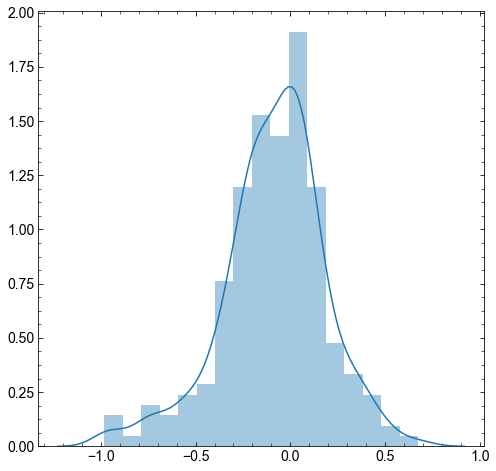

In [165]:
X = []
Y = []

plt.figure(figsize=[8,8])
for i in Sdb.query('SFa == "Q"').index:
    X.append(Sdb.Z[i])
    Y.append(Mdb.Z[i])

diff = (np.array(X)-np.array(Y)) 
sea.distplot(diff)
print(np.percentile(diff, 50),np.percentile(diff, 50)- np.percentile(diff, 16), np.percentile(diff, 84)-np.percentile(diff, 50))

# plt.plot([0,1.5],[0,1.5])
# plt.xlim(0,1.5)
# plt.ylim(0,1.5)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


0.15830109699848371 0.18613301117954584 0.24070555040330266
0.24906328781928 0.30450642172999753 0.31533356260673684


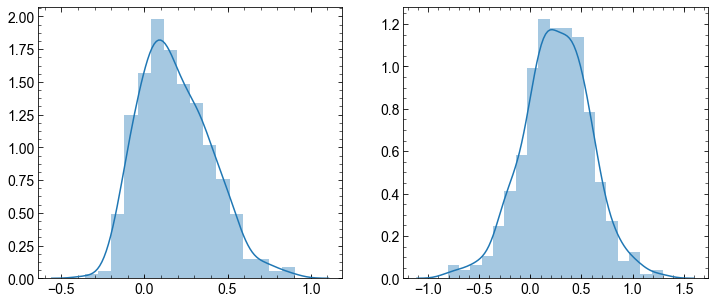

In [144]:
gs = gridspec.GridSpec(1,2)
plt.figure(figsize = [12,5])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

diff = list((Mdb.t_50.values - Sdb.t50.values) / Sdb.t50.values)
sea.distplot(np.array(diff), ax = ax1)
print(np.percentile(diff, 50),np.percentile(diff, 50)- np.percentile(diff, 16), np.percentile(diff, 84)-np.percentile(diff, 50))

diff = list((Mdb.t_50.values - Sdb.t50.values))
sea.distplot(np.array(diff), ax = ax2)
print(np.percentile(diff, 50),np.percentile(diff, 50)- np.percentile(diff, 16), np.percentile(diff, 84)-np.percentile(diff, 50))

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


-0.018340856851847907 0.2690301840804025 0.24743403969725963
-0.011698008660662285 0.2852003803287334 0.1264421490357621


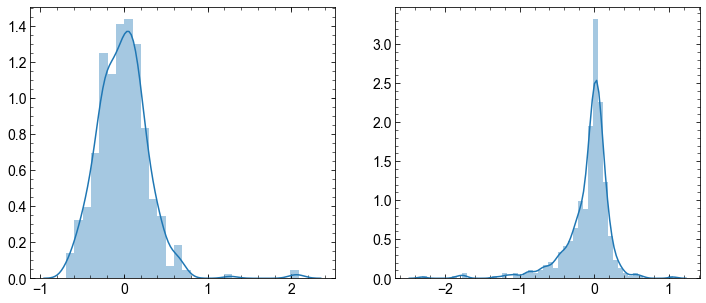

In [434]:
gs = gridspec.GridSpec(1,2)
plt.figure(figsize = [12,5])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

diff = list((Mdb.t_90.values - Sdb.t90.values) / Sdb.t90.values)
sea.distplot(np.array(diff), ax = ax1)
print(np.percentile(diff, 50),np.percentile(diff, 50)- np.percentile(diff, 16), np.percentile(diff, 84)-np.percentile(diff, 50))

diff = list((Mdb.t_90.values - Sdb.t90.values))
sea.distplot(np.array(diff), ax = ax2)
print(np.percentile(diff, 50),np.percentile(diff, 50)- np.percentile(diff, 16), np.percentile(diff, 84)-np.percentile(diff, 50))

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


-0.030912193832852895 0.28254481774381696 0.47231106195258526
-0.022096540164170286 0.311910388732191 0.25021304741732214


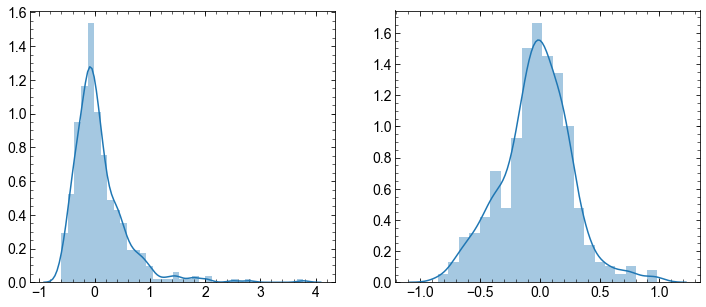

In [149]:
gs = gridspec.GridSpec(1,2)
plt.figure(figsize = [12,5])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

diff = list((Mdb.Z.values - Sdb.Z.values) / Sdb.Z.values)
sea.distplot(np.array(diff), ax = ax1)
print(np.percentile(diff, 50),np.percentile(diff, 50)- np.percentile(diff, 16), np.percentile(diff, 84)-np.percentile(diff, 50))

diff = list((Mdb.Z.values - Sdb.Z.values))
sea.distplot(np.array(diff), ax = ax2)
print(np.percentile(diff, 50),np.percentile(diff, 50)- np.percentile(diff, 16), np.percentile(diff, 84)-np.percentile(diff, 50))

109 0.5069767441860465
-0.030912193832852895 0.28254481774381696 0.47231106195258526


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


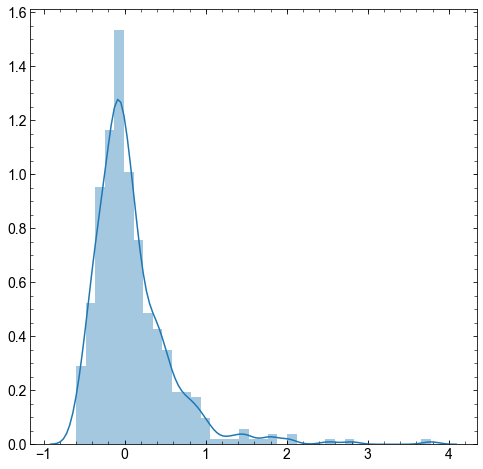

In [148]:
gs = gridspec.GridSpec(1,2)
plt.figure(figsize = [12,5])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

diff = list((Mdb.Z.values - Sdb.Z.values) / Sdb.Z.values)
sea.distplot(np.array(diff), ax = ax1)
print(np.percentile(diff, 50),np.percentile(diff, 50)- np.percentile(diff, 16), np.percentile(diff, 84)-np.percentile(diff, 50))

diff = list((Mdb.Z.values - Sdb.Z.values))
sea.distplot(np.array(diff), ax = ax2)
print(np.percentile(diff, 50),np.percentile(diff, 50)- np.percentile(diff, 16), np.percentile(diff, 84)-np.percentile(diff, 50))

In [465]:
Sdb.Z

0      0.5
1      0.5
2      0.5
3      0.1
4      0.5
      ... 
430    1.0
431    0.5
432    0.5
433    1.0
434    0.1
Name: Z, Length: 435, dtype: float64

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


0.013003482155157259 0.12077805467346905 0.11124793226688419
0.011087627895427055 0.07378157507140545 0.06898926344218266


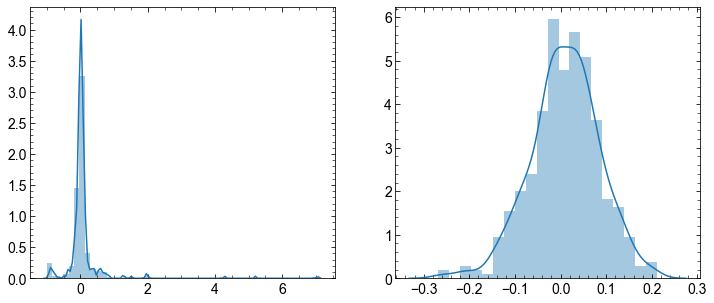

In [150]:
gs = gridspec.GridSpec(1,2)
plt.figure(figsize = [12,5])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

diff = list((Mdb.Av.values - Sdb.Av.values) / Sdb.Av.values)
diff = [U for U in diff if -100 < U < 100]
sea.distplot(np.array(diff), ax = ax1)
print(np.percentile(diff, 50),np.percentile(diff, 50)- np.percentile(diff, 16), np.percentile(diff, 84)-np.percentile(diff, 50))

diff = list((Mdb.Av.values - Sdb.Av.values))
sea.distplot(np.array(diff), ax = ax2)
print(np.percentile(diff, 50),np.percentile(diff, 50)- np.percentile(diff, 16), np.percentile(diff, 84)-np.percentile(diff, 50))

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


0.0 0.0005634385359925087 0.000724641884922903
0.0 0.0007196849357581226 0.0010441751504115437


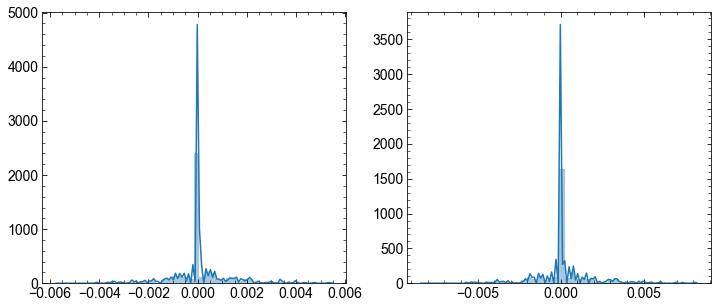

In [151]:
gs = gridspec.GridSpec(1,2)
plt.figure(figsize = [12,5])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

diff = list((Mdb.zgrism.values - Sdb.zgrism.values) / Sdb.zgrism.values)
sea.distplot(np.array(diff), ax = ax1)
print(np.percentile(diff, 50),np.percentile(diff, 50)- np.percentile(diff, 16), np.percentile(diff, 84)-np.percentile(diff, 50))

diff = list((Mdb.zgrism.values - Sdb.zgrism.values))
sea.distplot(np.array(diff), ax = ax2)
print(np.percentile(diff, 50),np.percentile(diff, 50)- np.percentile(diff, 16), np.percentile(diff, 84)-np.percentile(diff, 50))

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


-0.0007536897911821802 0.002446644332325374 0.00228560464011164
-0.008240451884557132 0.026877904666499294 0.02501179901144944


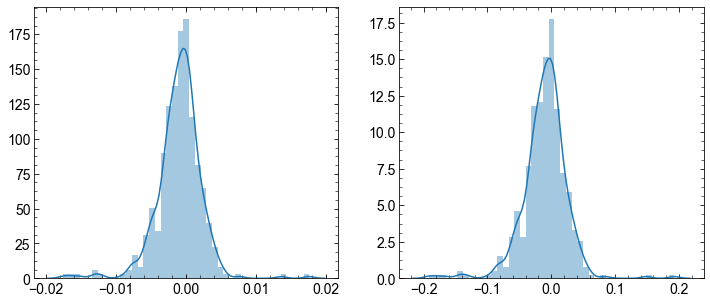

In [152]:
gs = gridspec.GridSpec(1,2)
plt.figure(figsize = [12,5])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

diff = list((Mdb.lmass.values - Sdb.lmass.values) / Sdb.lmass.values)
sea.distplot(np.array(diff), ax = ax1)
print(np.percentile(diff, 50),np.percentile(diff, 50)- np.percentile(diff, 16), np.percentile(diff, 84)-np.percentile(diff, 50))

diff = list((Mdb.lmass.values - Sdb.lmass.values))
sea.distplot(np.array(diff), ax = ax2)
print(np.percentile(diff, 50),np.percentile(diff, 50)- np.percentile(diff, 16), np.percentile(diff, 84)-np.percentile(diff, 50))

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


0.005037242601076107 0.014692894616097036 0.012975352877560718
-0.05048232099740524 0.12655673856197042 0.14598609299171217


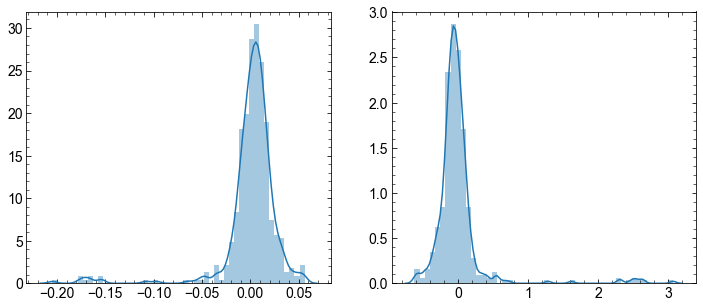

In [153]:
gs = gridspec.GridSpec(1,2)
plt.figure(figsize = [12,5])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

diff = list((Mdb.log_ssfr.values - Sdb.sSFR.values) / Sdb.sSFR.values)
sea.distplot(np.array(diff), ax = ax1)
print(np.percentile(diff, 50),np.percentile(diff, 50)- np.percentile(diff, 16), np.percentile(diff, 84)-np.percentile(diff, 50))

diff = list((Mdb.log_ssfr.values - Sdb.sSFR.values))
sea.distplot(np.array(diff), ax = ax2)
print(np.percentile(diff, 50),np.percentile(diff, 50)- np.percentile(diff, 16), np.percentile(diff, 84)-np.percentile(diff, 50))

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


-0.01266774967630423 0.014103739154983013 0.012956571342742959
0.13273649628804485 0.13560888466793244 0.13988823485330676


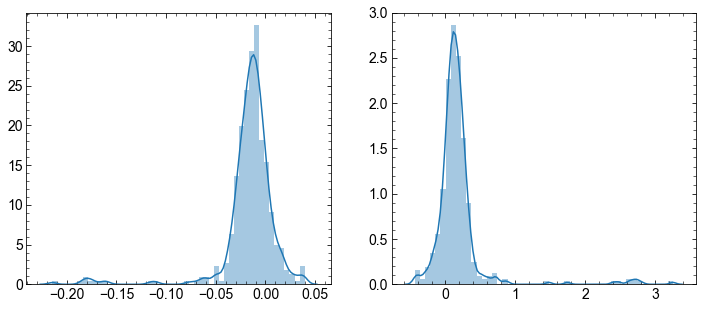

In [156]:
gs = gridspec.GridSpec(1,2)
plt.figure(figsize = [12,5])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

diff = list((Mdb.log_ssfr.values - Sdb.osSFR.values) / Sdb.osSFR.values)
sea.distplot(np.array(diff), ax = ax1)
print(np.percentile(diff, 50),np.percentile(diff, 50)- np.percentile(diff, 16), np.percentile(diff, 84)-np.percentile(diff, 50))

diff = list((Mdb.log_ssfr.values - Sdb.osSFR.values))
sea.distplot(np.array(diff), ax = ax2)
print(np.percentile(diff, 50),np.percentile(diff, 50)- np.percentile(diff, 16), np.percentile(diff, 84)-np.percentile(diff, 50))

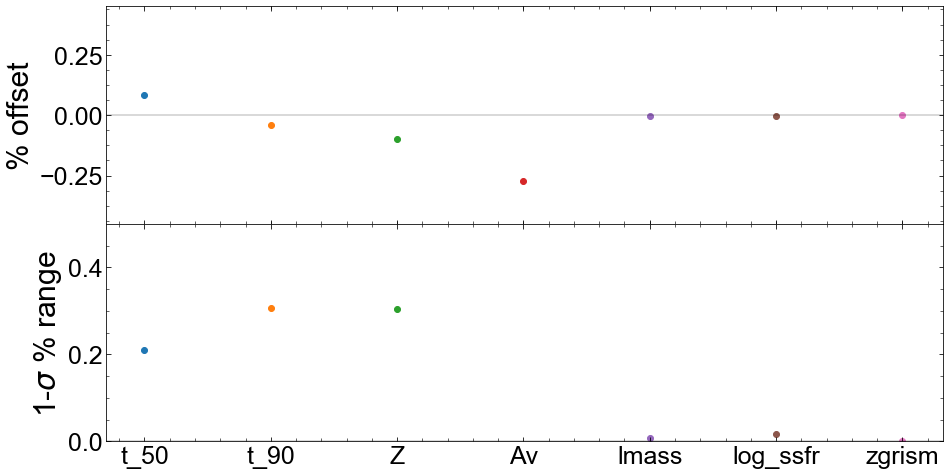

In [47]:
params = ['t_50','t_90', 'Z', 'Av', 'lmass', 'log_ssfr', 'zgrism']
in_params = ['t50','t90', '-Z-', '-Av-', '-lmass-', 'sSFR', '-zgrism-']
in_vals = [-99, -99, 1, 0.1, 11, -99, 1.5]

gs = gridspec.GridSpec(2,1, hspace=0)
plt.figure(figsize=[15,8])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

for i in range(len(params)):
    if in_vals[i] < 0:
        p_diff = list((Mdb['{}'.format(params[i])].values - Sdb['{}'.format(in_params[i])].values) / Sdb['{}'.format(in_params[i])].values)
    else:
        p_diff = list((Mdb['{}'.format(params[i])].values - in_vals[i]) / in_vals[i])
        
    m = np.percentile(p_diff, 50)
    lerr = np.percentile(p_diff, 50)- np.percentile(p_diff, 16)
    herr = np.percentile(p_diff, 84)-np.percentile(p_diff, 50)

    ax1.scatter(i, m)
    ax2.scatter(i, (lerr + herr)/2)

ax2.axhline(0, alpha = 0.2, color = 'k')
ax1.axhline(0, alpha = 0.2, color = 'k')
ax1.set_ylim(-0.45, 0.45)
ax2.set_ylim(0, .5)

ax2.set_xticks(np.arange(7))
ax2.set_xticklabels(['t_50','t_90', 'Z', 'Av', 'lmass', 'log_ssfr', 'zgrism'])
ax1.set_ylabel('% offset', fontsize=30)
ax2.set_ylabel('1-$\sigma$ % range', fontsize=30)
ax1.tick_params(axis='both', which='major', labelsize=25)
ax2.tick_params(axis='both', which='major', labelsize=25)

In [15]:
np.linspace(0,140, 15)

array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
       110., 120., 130., 140.])

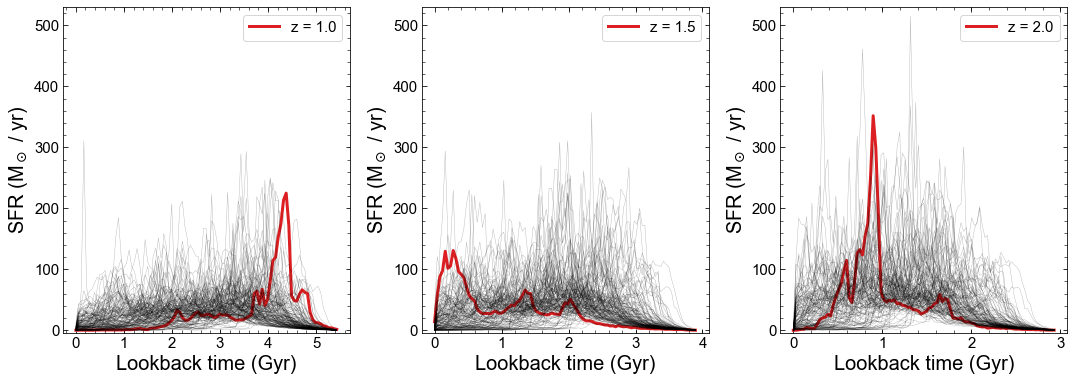

In [227]:
gs = gridspec.GridSpec(1,3, wspace=0.25)

plt.figure(figsize=[18,6])

ax1 = plt.subplot(gs[0])
db = Sdb.query('zgrism == 1.0')
idx = 0
for i in db.index:
    lbt, sfh = np.load('../sim_SFH/SFH_z1.0_{}.npy'.format(Sdb.gid[i]), allow_pickle = True)
    lbt = lbt - min(lbt)
    ax1.plot(lbt,sfh, 'k', linewidth =0.4, alpha = 0.3)
    if idx == 45:
        ax1.plot(lbt,sfh, '#dc1f22', linewidth =3, alpha = 1, label = 'z = 1.0')
    idx += 1 

ax2 = plt.subplot(gs[1])
db = Sdb.query('zgrism == 1.5')
idx = 0
for i in db.index:
    lbt, sfh = np.load('../sim_SFH/SFH_z1.5_{}.npy'.format(Sdb.gid[i]), allow_pickle = True)
    lbt = lbt - min(lbt)
    ax2.plot(lbt,sfh, 'k', linewidth =0.4, alpha = 0.3)
    if idx == 46:
        ax2.plot(lbt,sfh, '#dc1f22', linewidth =3, alpha = 1, label = 'z = 1.5')
    idx += 1
    
ax3 = plt.subplot(gs[2])
db = Sdb.query('zgrism == 2.0')
idx = 0
for i in db.index:
    lbt, sfh = np.load('../sim_SFH/SFH_z2.0_{}.npy'.format(Sdb.gid[i]), allow_pickle = True)
    lbt = lbt - min(lbt)
    ax3.plot(lbt,sfh , 'k', linewidth =0.4, alpha = 0.3)
    if idx == 23:
        ax3.plot(lbt,sfh, '#dc1f22', linewidth =3, alpha = 1, label = 'z = 2.0')
    idx += 1 
    
ax1.set_xlabel('Lookback time (Gyr)', fontsize=20)
ax1.set_ylabel('SFR (M$_\odot$ / yr)', fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax2.set_xlabel('Lookback time (Gyr)', fontsize=20)
ax2.set_ylabel('SFR (M$_\odot$ / yr)', fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax3.set_xlabel('Lookback time (Gyr)', fontsize=20)
ax3.set_ylabel('SFR (M$_\odot$ / yr)', fontsize=20)
ax3.tick_params(axis='both', which='major', labelsize=15)
ax1.set_ylim(-5,530)
ax2.set_ylim(-5,530)
ax3.set_ylim(-5,530)
ax1.legend(fontsize = 15)
ax2.legend(fontsize = 15)
ax3.legend(fontsize = 15)
plt.savefig('../plots/evolution_plots/all_sim_sfhs.pdf', bbox_inches = 'tight')    

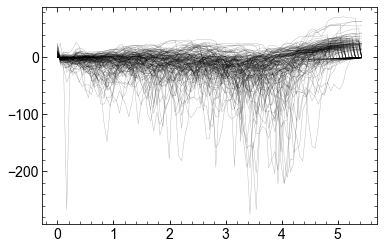

In [74]:
ax1 = plt.subplot()
db = Sdb.query('zgrism == 1.0')

diff_grid = []

for i in db.index:
    lbt, sfh = np.load('../sim_SFH/SFH_z1.0_{}.npy'.format(Sdb.gid[i]), allow_pickle = True)
    lbt = lbt - min(lbt)
    
    LBT, SFH = np.load('../data/SFH/z1.0_{}_imp.npy'.format(Sdb.gid[i]), allow_pickle = True)
    iSFH = interp1d(LBT, SFH, bounds_error=False, fill_value=0)(lbt)
    ax1.plot(lbt,iSFH - sfh, 'k', linewidth =0.4, alpha = 0.3)
    diff_grid.append(iSFH - sfh)

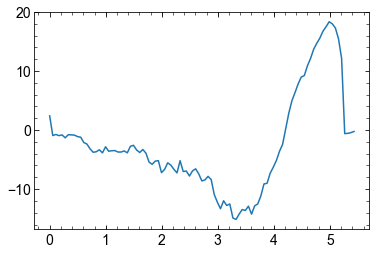

In [75]:
plt.plot(lbt, np.percentile(diff_grid, 50, axis = 0))

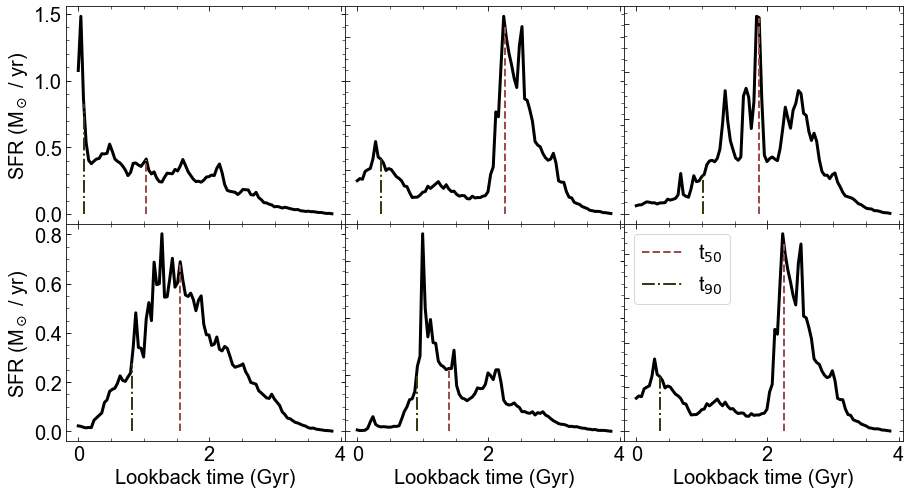

In [220]:
gs = gridspec.GridSpec(2,3, wspace= 0, hspace= 0)

plt.figure(figsize=[15,8])

for i in range(6):
    ax=plt.subplot(gs[i])

    gid = np.random.choice(np.arange(174))
    
    lbt, sfh = np.load('../sim_SFH/SFH_{}.npy'.format(gid),allow_pickle = True)
    sfh = sfh[1:]
    lbt = lbt[:-1]

    ax.plot(lbt, sfh, 'k', linewidth = 3, alpha = 1)

    isfh  = interp1d(lbt, sfh)

    ax.plot([Sdb.t50[gid],Sdb.t50[gid]], [0,isfh(Sdb.t50[gid])], '--', color = '#9C4D4D', linewidth = 2, label = 't$_{50}$')
    ax.plot([Sdb.t90[gid],Sdb.t90[gid]], [0,isfh(Sdb.t90[gid])], '-.', color = '#393910', linewidth = 2, label = 't$_{90}$')

    if i not in [0,3]:
        ax.set_yticklabels([])
    if i >= 3 :
#         ax.set_xticklabels([])
        ax.set_xlabel('Lookback time (Gyr)', fontsize=20)

    if i in [0,3]:
        ax.set_ylabel('SFR (M$_\odot$ / yr)', fontsize=20)
    if i  == 5:
        ax.legend(fontsize = 20)
    ax.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('../plots/evolution_plots/sim_sfhs/gal_{}.pdf'.format(gid), bbox_inches = 'tight')    

In [ ]:
Mdb['t_q'] = Mdb.t_50.values - Mdb.t_90.values

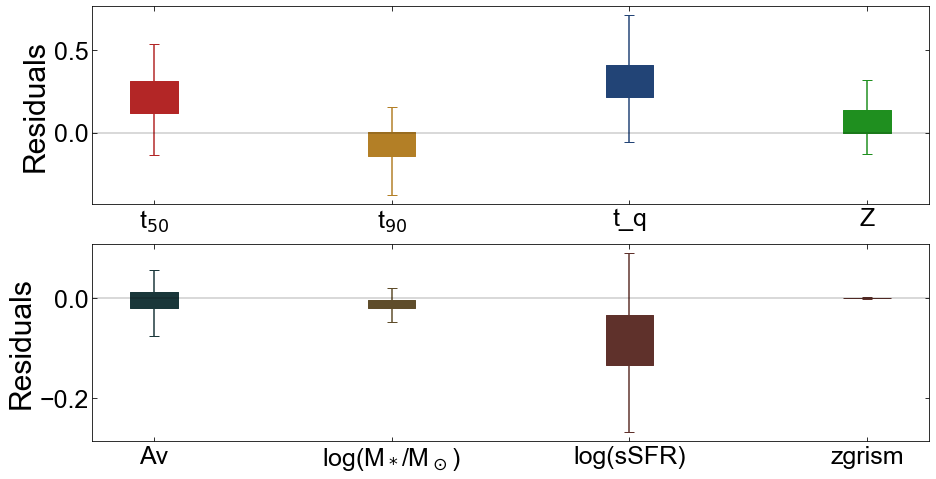

In [243]:
params = ['t_50','t_90', 't_q', 'Z', 'Av', 'lmass', 'log_ssfr', 'zgrism']
in_params = ['t50','t90', 'tq', 'Z', 'Av', 'lmass', 'sSFR', 'zgrism']

gs = gridspec.GridSpec(2,1)

plt.figure(figsize=[15,8])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
col = ['#B32626', '#B37F26','#224476','#1F8F1F','#1A373A','#5F4D2B','#5F312B','#5F312B']

for i in range(len(params)):
#     p_diff = list((Mdb['{}'.format(params[i])].values - Sdb['{}'.format(in_params[i])].values) / Sdb['{}'.format(in_params[i])].values)
    p_diff = list((Mdb.query('SFa == "Q"')['{}'.format(params[i])].values - Sdb.query('SFa == "Q"')['{}'.format(in_params[i])].values))
    p_diff = [U for U in p_diff if -100 < U < 100]

        
    m = np.percentile(p_diff, 50)
    lerr = np.percentile(p_diff, 40)
    herr = np.percentile(p_diff, 60)

    if i < 4:
        ax = ax1
    else:
        ax = ax2
        
    ax.fill_between([i-0.1,i+0.1], [lerr, lerr], [herr, herr], color = col[i])
    
    lerr = m - np.percentile(p_diff, 16)
    herr = np.percentile(p_diff,84) - m
    ax.errorbar(i, m,[[lerr], [herr]], capsize = 5, color = col[i])

ax1.axhline(0, alpha = 0.2, color = 'k')
ax2.axhline(0, alpha = 0.2, color = 'k')
# plt.ylim(-0.45, 0.45)
ax1.set_ylabel('Residuals', fontsize=30)
ax2.set_ylabel('Residuals', fontsize=30)

ax1.tick_params(axis='both', which='major', labelsize=25)
ax2.tick_params(axis='both', which='major', labelsize=25)

ax1.set_xticks(range(4))
ax2.set_xticks(np.arange(4)+4)
ax1.set_xticklabels(['t$_{50}$','t$_{90}$', 't_q', 'Z'])
ax2.set_xticklabels(['Av', 'log(M$_*$/M$_\odot$)', 'log(sSFR)', 'zgrism'])

ax1.minorticks_off()
ax2.minorticks_off()


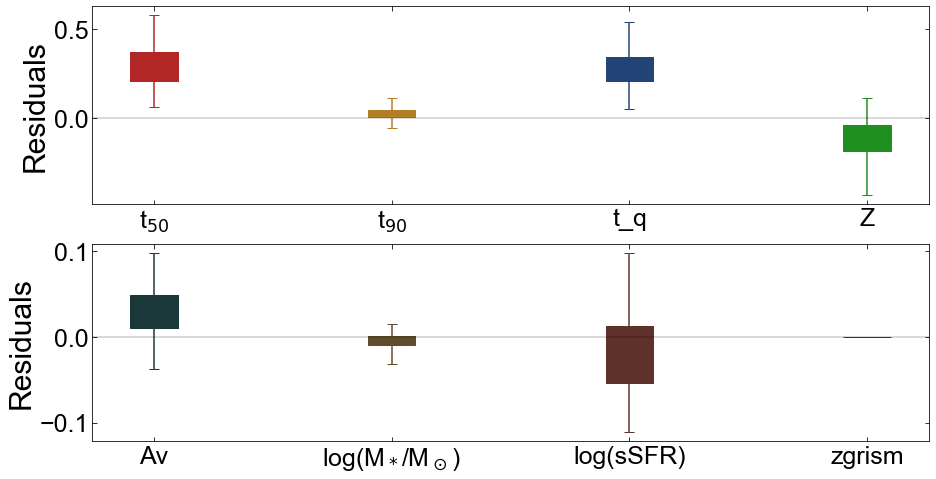

In [244]:
params = ['t_50','t_90', 't_q', 'Z', 'Av', 'lmass', 'log_ssfr', 'zgrism']
in_params = ['t50','t90', 'tq', 'Z', 'Av', 'lmass', 'sSFR', 'zgrism']

gs = gridspec.GridSpec(2,1)

plt.figure(figsize=[15,8])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
col = ['#B32626', '#B37F26','#224476','#1F8F1F','#1A373A','#5F4D2B','#5F312B','#5F312B']

for i in range(len(params)):
#     p_diff = list((Mdb['{}'.format(params[i])].values - Sdb['{}'.format(in_params[i])].values) / Sdb['{}'.format(in_params[i])].values)
    p_diff = list((Mdb.query('SFa == "S"')['{}'.format(params[i])].values - Sdb.query('SFa == "S"')['{}'.format(in_params[i])].values))
    p_diff = [U for U in p_diff if -100 < U < 100]

        
    m = np.percentile(p_diff, 50)
    lerr = np.percentile(p_diff, 40)
    herr = np.percentile(p_diff, 60)

    if i < 4:
        ax = ax1
    else:
        ax = ax2
        
    ax.fill_between([i-0.1,i+0.1], [lerr, lerr], [herr, herr], color = col[i])
    
    lerr = m - np.percentile(p_diff, 16)
    herr = np.percentile(p_diff,84) - m
    ax.errorbar(i, m,[[lerr], [herr]], capsize = 5, color = col[i])

ax1.axhline(0, alpha = 0.2, color = 'k')
ax2.axhline(0, alpha = 0.2, color = 'k')
# plt.ylim(-0.45, 0.45)
ax1.set_ylabel('Residuals', fontsize=30)
ax2.set_ylabel('Residuals', fontsize=30)

ax1.tick_params(axis='both', which='major', labelsize=25)
ax2.tick_params(axis='both', which='major', labelsize=25)

ax1.set_xticks(range(4))
ax2.set_xticks(np.arange(4)+4)
ax1.set_xticklabels(['t$_{50}$','t$_{90}$', 't_q', 'Z'])
ax2.set_xticklabels(['Av', 'log(M$_*$/M$_\odot$)', 'log(sSFR)', 'zgrism'])

ax1.minorticks_off()
ax2.minorticks_off()


In [274]:
Mdb.t_50

0       2.486787
1       2.802147
2       2.718574
3       2.391612
4       3.302287
         ...    
430   -99.000000
431   -99.000000
432   -99.000000
433   -99.000000
434   -99.000000
Name: t_50, Length: 435, dtype: float64

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


0.1499906776245239 0.34118292145775164 0.3677996956080354
0.2565884189577984 0.29125322511771873 0.295476843479603
-0.12140608591383506 0.3226801425950764 0.19244300669975856
-0.02085244413740797 0.10791315760205933 0.06961571119696637
0.06217835284405404 0.1947241069573455 0.25503579677916943
-0.10739263008592903 0.32263680761649743 0.22188997134455624
-0.008093292652002204 0.06754216059459998 0.06363589289639676
0.03230966101063343 0.06999712653434668 0.0658107327148173
-0.011765826542161406 0.03624652262295363 0.03105219228305862
-0.004230431976499638 0.02752951876776063 0.01892740286597831
-0.09814901178454605 0.18521803844925067 0.16485224743667692
-0.023243213504753335 0.09803397748414998 0.12068988765063683


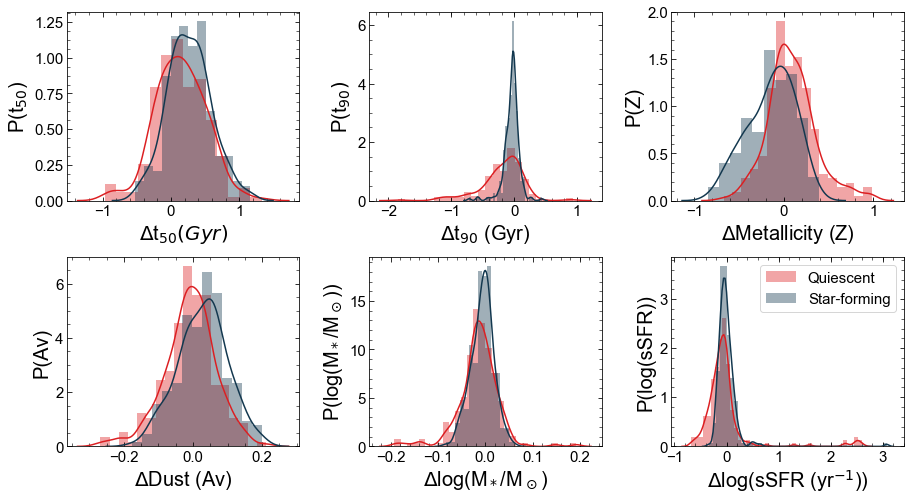

In [276]:
params = ['t_50','t_90', 'Z', 'Av', 'lmass', 'log_ssfr']
in_params = ['t50','t90', 'Z', 'Av', 'lmass', 'sSFR']
x_labels = ['t$_{50} (Gyr)$','t$_{90}$ (Gyr)', 'Metallicity (Z)', 'Dust (Av)', 'log(M$_*$/M$_\odot$)', 'log(sSFR (yr$^{-1}$))']
y_labels = ['P(t$_{50}$)','P(t$_{90})$', 'P(Z)', 'P(Av)', 'P(log(M$_*$/M$_\odot$))', 'P(log(sSFR))']

gs = gridspec.GridSpec(2,3, hspace=0.3, wspace = 0.3)

plt.figure(figsize=[15,8])

for i in range(len(params)):
    ax = plt.subplot(gs[i])

    diff = list((Mdb.query('SFa == "Q"')['{}'.format(params[i])].values - Sdb.query('SFa == "Q"')['{}'.format(in_params[i])].values))
    sea.distplot(diff, color = '#dc1f22', label ='Quiescent')
    print(np.percentile(diff, 50),np.percentile(diff, 50)- np.percentile(diff, 16), np.percentile(diff, 84)-np.percentile(diff, 50))
    diff = list((Mdb.query('SFa == "S"')['{}'.format(params[i])].values - Sdb.query('SFa == "S"')['{}'.format(in_params[i])].values))
    sea.distplot(diff, color = '#13384f', label ='Star-forming')
    print(np.percentile(diff, 50),np.percentile(diff, 50)- np.percentile(diff, 16), np.percentile(diff, 84)-np.percentile(diff, 50))
    ax.set_xlabel('$\Delta$' + x_labels[i], fontsize=20)
    ax.set_ylabel(y_labels[i], fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    if i ==5:
        ax.legend(loc = 1, fontsize = 15)
        
plt.savefig('../plots/evolution_plots/sim_compare_sfa.pdf', bbox_inches = 'tight')    

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


0.2565884189577984 0.29125322511771873 0.295476843479603
0.2542534585561376 0.2439504911400929 0.304955019840539
-0.02085244413740797 0.10791315760205933 0.06961571119696637
-0.033373311334372685 0.09332417064001788 0.08612093817567382
-0.10739263008592903 0.32263680761649743 0.22188997134455624
-0.24389062205685405 0.3270956780840545 0.22171476870104095
0.03230966101063343 0.06999712653434668 0.0658107327148173
0.06068487336451506 0.07099095916268586 0.0711771481140197
-0.004230431976499638 0.02752951876776063 0.01892740286597831
-0.00328390425125491 0.023710970570243146 0.020625453532300265
-0.023243213504753335 0.09803397748414998 0.12068988765063683
-0.01218070422790607 0.08916495106796529 0.11005354076195481


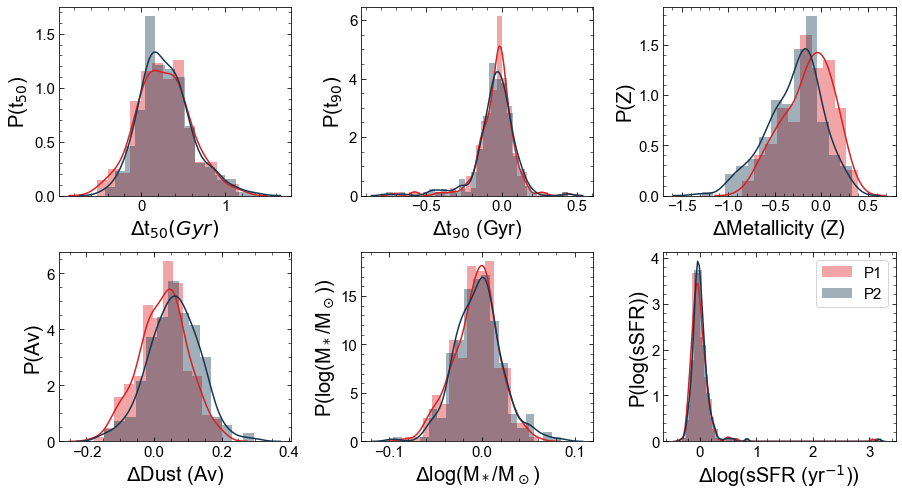

In [5]:
params = ['t_50','t_90', 'Z', 'Av', 'lmass', 'log_ssfr']
in_params = ['t50','t90', 'Z', 'Av', 'lmass', 'sSFR']
x_labels = ['t$_{50} (Gyr)$','t$_{90}$ (Gyr)', 'Metallicity (Z)', 'Dust (Av)', 'log(M$_*$/M$_\odot$)', 'log(sSFR (yr$^{-1}$))']
y_labels = ['P(t$_{50}$)','P(t$_{90})$', 'P(Z)', 'P(Av)', 'P(log(M$_*$/M$_\odot$))', 'P(log(sSFR))']

gs = gridspec.GridSpec(2,3, hspace=0.3, wspace = 0.3)

plt.figure(figsize=[15,8])

for i in range(len(params)):
    ax = plt.subplot(gs[i])

    diff = list((Mdb.query('SFa == "S"')['{}'.format(params[i])].values - Sdb.query('SFa == "S"')['{}'.format(in_params[i])].values))
    sea.distplot(diff, color = '#dc1f22', label ='P1')
    print(np.percentile(diff, 50),np.percentile(diff, 50)- np.percentile(diff, 16), np.percentile(diff, 84)-np.percentile(diff, 50))
    diff = list((P2db.query('SFa == "S"')['{}'.format(params[i])].values - Sdb.query('SFa == "S"')['{}'.format(in_params[i])].values))
    sea.distplot(diff, color = '#13384f', label ='P2')
    print(np.percentile(diff, 50),np.percentile(diff, 50)- np.percentile(diff, 16), np.percentile(diff, 84)-np.percentile(diff, 50))
    ax.set_xlabel('$\Delta$' + x_labels[i], fontsize=20)
    ax.set_ylabel(y_labels[i], fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    if i ==5:
        ax.legend(loc = 1, fontsize = 15)
        
# plt.savefig('../plots/evolution_plots/sim_compare_sfa.pdf', bbox_inches = 'tight')    

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


0.4374100369425987 0.478738950678688 0.8154847075679218
-0.024826033631884847 0.5932959735896917 0.49668500726972714
0.19415284173735103 0.31772260242736566 0.343178008410596
-0.19765852336607243 1.0902242975127594 0.20330596956451438
-0.1981444305551107 0.3798542601645879 0.19979251346844323
-0.04386149563832134 0.24340739821119514 0.10572538768460982
-0.06083196869938945 0.361224060132511 0.2996582742641725
-0.032252560938213604 0.3327134648812902 0.2558767613921764
-0.022096540164170286 0.311910388732191 0.25021304741732214
0.021806658642261834 0.09541765158202525 0.08867367229236031
0.03520132934505549 0.2646024944468326 0.35654082177976076
0.011087627895427055 0.07378157507140545 0.06898926344218266
-0.009571821352775345 0.02737123519595705 0.02211885042406614
0.05644355414506386 0.1189494959134425 0.11178959746233202
-0.008240451884557132 0.026877904666499294 0.02501179901144944
0.5208547225133291 0.5631479946076524 0.9052754809027594
0.19772157915025268 0.471123185573799 0.45826

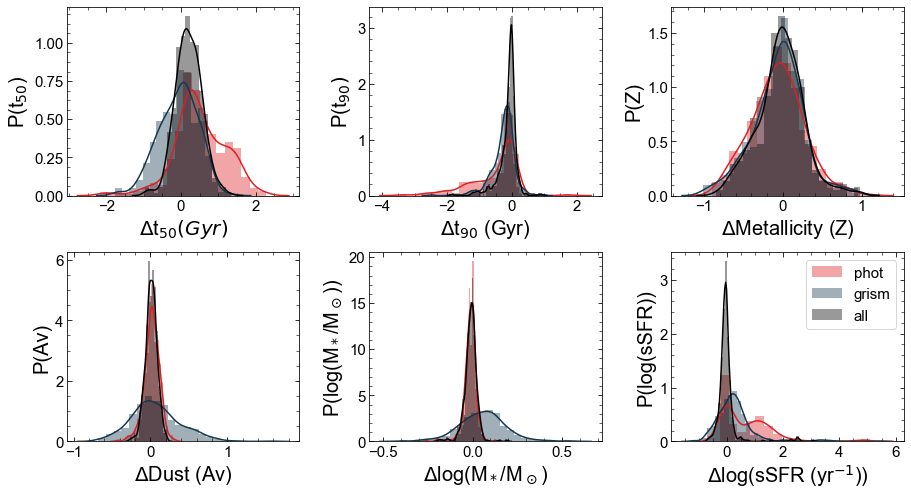

In [8]:
params = ['t_50','t_90', 'Z', 'Av', 'lmass', 'log_ssfr']
in_params = ['t50','t90', 'Z', 'Av', 'lmass', 'sSFR']
x_labels = ['t$_{50} (Gyr)$','t$_{90}$ (Gyr)', 'Metallicity (Z)', 'Dust (Av)', 'log(M$_*$/M$_\odot$)', 'log(sSFR (yr$^{-1}$))']
y_labels = ['P(t$_{50}$)','P(t$_{90})$', 'P(Z)', 'P(Av)', 'P(log(M$_*$/M$_\odot$))', 'P(log(sSFR))']

gs = gridspec.GridSpec(2,3, hspace=0.3, wspace = 0.3)

plt.figure(figsize=[15,8])

for i in range(len(params)):
    ax = plt.subplot(gs[i])

    diff = list((Pdb['{}'.format(params[i])].values - Sdb['{}'.format(in_params[i])].values))
    sea.distplot(diff, color = '#dc1f22', label ='phot')
    print(np.percentile(diff, 50),np.percentile(diff, 50)- np.percentile(diff, 16), np.percentile(diff, 84)-np.percentile(diff, 50))
    diff = list((Gdb['{}'.format(params[i])].values - Sdb['{}'.format(in_params[i])].values))
    sea.distplot(diff, color = '#13384f', label ='grism')
    print(np.percentile(diff, 50),np.percentile(diff, 50)- np.percentile(diff, 16), np.percentile(diff, 84)-np.percentile(diff, 50))
    diff = list((Mdb['{}'.format(params[i])].values - Sdb['{}'.format(in_params[i])].values))
    sea.distplot(diff, color = 'k', label ='all')
    print(np.percentile(diff, 50),np.percentile(diff, 50)- np.percentile(diff, 16), np.percentile(diff, 84)-np.percentile(diff, 50))
    ax.set_xlabel('$\Delta$' + x_labels[i], fontsize=20)
    ax.set_ylabel(y_labels[i], fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    if i ==5:
        ax.legend(loc = 1, fontsize = 15)
        
# plt.savefig('../plots/evolution_plots/sim_compare_sfa.pdf', bbox_inches = 'tight')    

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


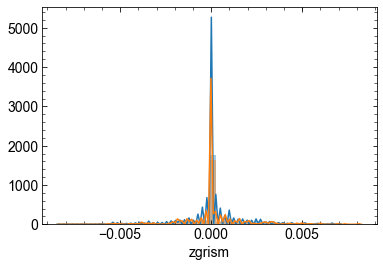

In [15]:
# sea.distplot(Pdb.zgrism-Sdb.zgrism)
sea.distplot(Gdb.zgrism-Sdb.zgrism)
sea.distplot(Mdb.zgrism-Sdb.zgrism)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


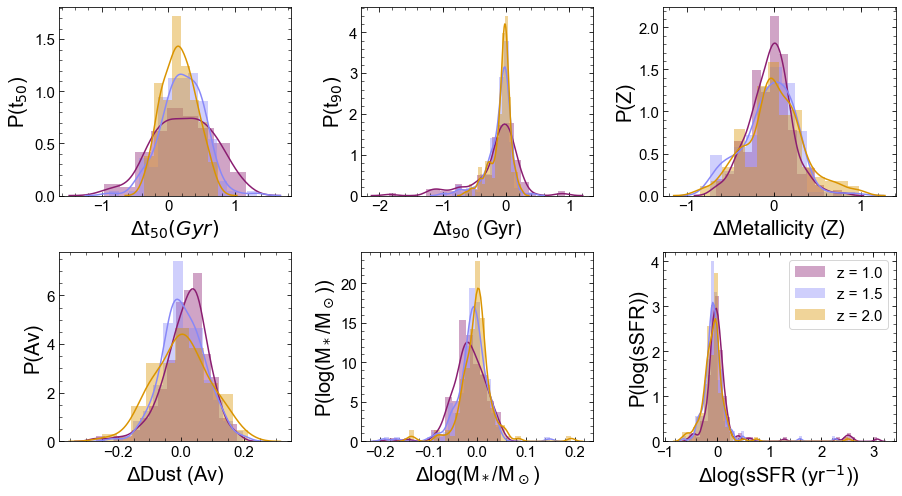

In [277]:
params = ['t_50','t_90', 'Z', 'Av', 'lmass', 'log_ssfr']
in_params = ['t50','t90', 'Z', 'Av', 'lmass', 'sSFR']
x_labels = ['t$_{50} (Gyr)$','t$_{90}$ (Gyr)', 'Metallicity (Z)', 'Dust (Av)', 'log(M$_*$/M$_\odot$)', 'log(sSFR (yr$^{-1}$))']
y_labels = ['P(t$_{50}$)','P(t$_{90})$', 'P(Z)', 'P(Av)', 'P(log(M$_*$/M$_\odot$))', 'P(log(sSFR))']

gs = gridspec.GridSpec(2,3, hspace=0.3, wspace = 0.3)

plt.figure(figsize=[15,8])

for i in range(len(params)):
    ax = plt.subplot(gs[i])

    diff = list((Mdb.query('0.9 < zgrism < 1.1')['{}'.format(params[i])].values \
                 - Sdb.query('zgrism == 1.0')['{}'.format(in_params[i])].values))
    sea.distplot(diff, color = '#8a1d71', label ='z = 1.0')

    diff = list((Mdb.query('1.4 < zgrism < 1.6')['{}'.format(params[i])].values \
                 - Sdb.query('zgrism == 1.5')['{}'.format(in_params[i])].values))
    sea.distplot(diff, color = '#8888f8', label ='z = 1.5')
    
    diff = list((Mdb.query('1.9 < zgrism < 2.1')['{}'.format(params[i])].values \
                 - Sdb.query('zgrism == 2.0')['{}'.format(in_params[i])].values))
    sea.distplot(diff, color = '#da9400', label ='z = 2.0')
    
    ax.set_xlabel('$\Delta$' + x_labels[i], fontsize=20)
    ax.set_ylabel(y_labels[i], fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    if i ==5:
        ax.legend(loc = 1, fontsize = 15)
plt.savefig('../plots/evolution_plots/sim_compare_z.pdf', bbox_inches = 'tight')    

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


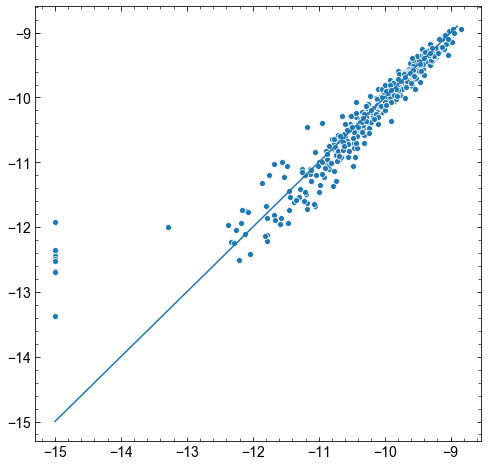

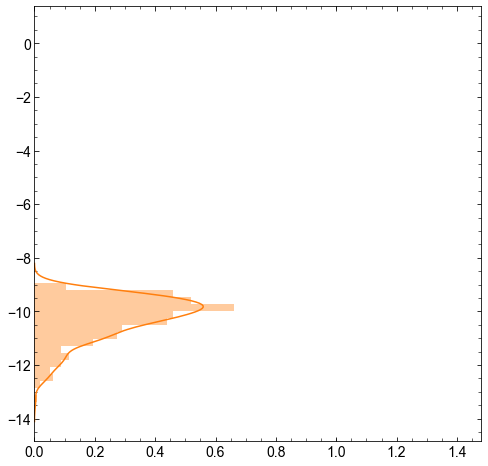

In [79]:
plt.figure(figsize=[8,8])
sea.scatterplot(Sdb['sSFR'].values, Mdb['log_ssfr'].values)
plt.plot([-15,-8.9],[-15,-8.9])

plt.figure(figsize=[8,8])
sea.distplot(Sdb['sSFR'].values)
sea.distplot(Mdb['log_ssfr'].values, vertical = True)

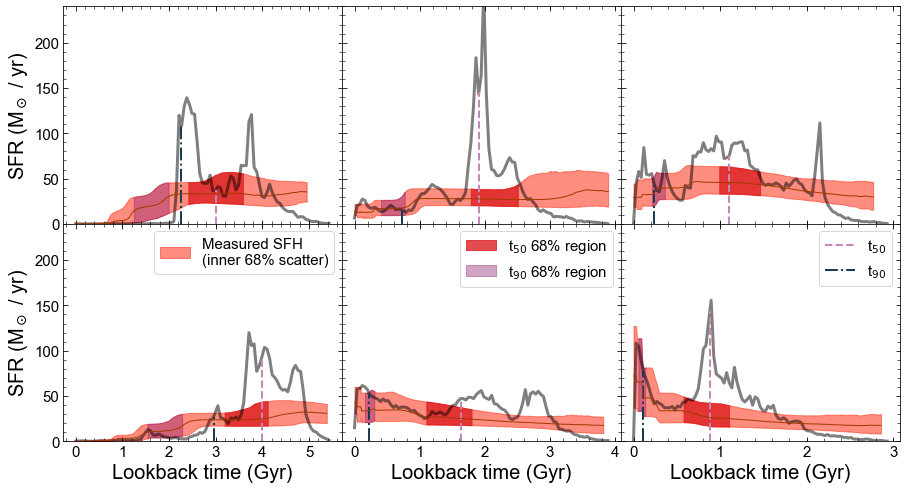

In [313]:
zs = ['1.0','1.5','2.0','1.0','1.5','2.0']

gs = gridspec.GridSpec(2,3, wspace= 0, hspace= 0)

plt.figure(figsize=[15,8])

for i in range(6):
    ax=plt.subplot(gs[i])

    Gid = np.random.choice(np.arange(135))
    
    gid = Sdb.query('zgrism == {} and gid == {}'.format(zs[i], Gid)).index.values[0]
    
    LBT,SFH = np.load('../data/SFH/z{}_{}_imp.npy'.format(zs[i],Gid))
    LBT,SFH16 = np.load('../data/SFH/z{}_{}_imp_16.npy'.format(zs[i],Gid))
    LBT,SFH84 = np.load('../data/SFH/z{}_{}_imp_84.npy'.format(zs[i],Gid))

    
    lbt, sfh = np.load('../sim_SFH/SFH_z{}_{}.npy'.format(zs[i],Gid),allow_pickle = True)
    lbt = lbt - min(lbt)

    ax.plot(lbt, sfh, 'k', linewidth = 3, alpha = 0.5)

    isfh  = interp1d(lbt, sfh)

    if i == 5:
        ax.plot([Sdb.t50[gid],Sdb.t50[gid]], [0,isfh(Sdb.t50[gid])], '--', 
                color = '#c586b8', linewidth = 2, label = 't$_{50}$')
        ax.plot([Sdb.t90[gid],Sdb.t90[gid]], [0,isfh(Sdb.t90[gid])], '-.', 
                color = '#173c53', linewidth = 2, label = 't$_{90}$')
    else:
        ax.plot([Sdb.t50[gid],Sdb.t50[gid]], [0,isfh(Sdb.t50[gid])], '--', color = '#c586b8', linewidth = 2)
        ax.plot([Sdb.t90[gid],Sdb.t90[gid]], [0,isfh(Sdb.t90[gid])], '-.', color = '#173c53', linewidth = 2)
    
    ax.plot(LBT, SFH, "#a43900", linewidth = 1)
    
    if i == 3:
        ax.fill_between(LBT, SFH16,  SFH84, 
                        color = '#ff1d00', alpha = 0.5, label = 'Measured SFH\n(inner 68% scatter)')
    else:    
        ax.fill_between(LBT, SFH16,  SFH84 , color = '#ff1d00', alpha = 0.5)
    
    iSFH16  = interp1d(LBT, SFH16)
    iSFH84  = interp1d(LBT, SFH84)
    
    t50_range  = np.linspace(Mdb.t_50_hdr[gid][0],Mdb.t_50_hdr[gid][1], 100)
    t90_range  = np.linspace(Mdb.t_90_hdr[gid][0],Mdb.t_90_hdr[gid][1], 100)

    if i == 4:
        ax.fill_between(t50_range, iSFH16(t50_range), iSFH84(t50_range), 
                        alpha = 0.8, color = '#dc1f22', label = 't$_{50}$ 68% region')
        ax.fill_between(t90_range, iSFH16(t90_range), iSFH84(t90_range), 
                        alpha = 0.4, color = '#8a1c70', label = 't$_{90}$ 68% region')
    else:
        ax.fill_between(t50_range, iSFH16(t50_range), iSFH84(t50_range), alpha = 0.8, color = '#dc1f22')
        ax.fill_between(t90_range, iSFH16(t90_range), iSFH84(t90_range), alpha = 0.4, color = '#8a1c70')
    
    if i not in [0,3]:
        ax.set_yticklabels([])
    if i >= 3 :
#         ax.set_xticklabels([])
        ax.set_xlabel('Lookback time (Gyr)', fontsize=20)
        ax.legend(fontsize = 15)

    if i in [0,3]:
        ax.set_ylabel('SFR (M$_\odot$ / yr)', fontsize=20)
    
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_ylim(0,240)

plt.savefig('../plots/evolution_plots/illustris_sim_fits_10.png', bbox_inches = 'tight')    

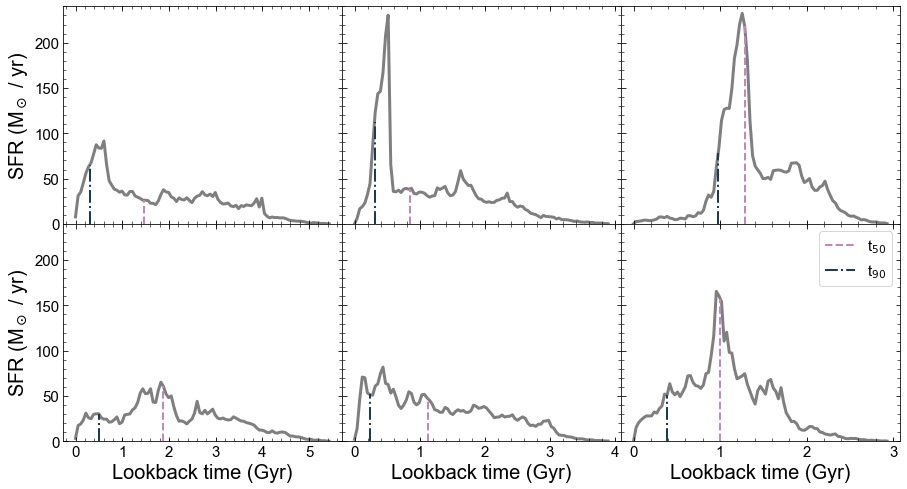

In [292]:
zs = ['1.0','1.5','2.0','1.0','1.5','2.0']

gs = gridspec.GridSpec(2,3, wspace= 0, hspace= 0)

plt.figure(figsize=[15,8])

for i in range(6):
    ax=plt.subplot(gs[i])

    Gid = np.random.choice(np.arange(135))
    
    gid = Sdb.query('zgrism == {} and gid == {}'.format(zs[i], Gid)).index.values[0]
    
    lbt, sfh = np.load('../sim_SFH/SFH_z{}_{}.npy'.format(zs[i],Gid),allow_pickle = True)
    lbt = lbt - min(lbt)

    ax.plot(lbt, sfh, 'k', linewidth = 3, alpha = 0.5)

    isfh  = interp1d(lbt, sfh)

    if i == 5:
        ax.plot([Sdb.t50[gid],Sdb.t50[gid]], [0,isfh(Sdb.t50[gid])], '--', 
                color = '#c586b8', linewidth = 2, label = 't$_{50}$')
        ax.plot([Sdb.t90[gid],Sdb.t90[gid]], [0,isfh(Sdb.t90[gid])], '-.', 
                color = '#173c53', linewidth = 2, label = 't$_{90}$')
    else:
        ax.plot([Sdb.t50[gid],Sdb.t50[gid]], [0,isfh(Sdb.t50[gid])], '--', color = '#c586b8', linewidth = 2)
        ax.plot([Sdb.t90[gid],Sdb.t90[gid]], [0,isfh(Sdb.t90[gid])], '-.', color = '#173c53', linewidth = 2)

    if i not in [0,3]:
        ax.set_yticklabels([])
    if i >= 3 :
        ax.set_xlabel('Lookback time (Gyr)', fontsize=20)
    if i >= 5 :
        ax.legend(fontsize = 15)

    if i in [0,3]:
        ax.set_ylabel('SFR (M$_\odot$ / yr)', fontsize=20)
    
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_ylim(0,240)
plt.savefig('../plots/evolution_plots/illustris_sim.png', bbox_inches = 'tight')    

In [21]:
#!/home/vestrada78840/miniconda3/envs/astroconda/bin/python
from spec_id import *
from spec_exam import Gen_spec_2D
import fsps
import numpy as np
from glob import glob
import pandas as pd
import os
import sys
from time import time
hpath = os.environ['HOME'] + '/'
START = time()
    
galaxy = 1
specz = 1.5
logmass = 11
lwa = 1.2
    
verbose=False
poolsize = 8

agelim = Oldest_galaxy(specz)
zscale = 0.0035 * (1 + specz)

# lbt, sfh = np.load(data_path + 'sim_SFH/SFH_{}.npy'.format(galaxy),allow_pickle = True)
lbt, sfh = np.load('../sim_SFH/SFH_{}.npy'.format(galaxy),allow_pickle = True)

sfh = sfh[1:]
lbt = lbt[:-1]


############ simulate data with no offsets#############

#########define fsps and gen spec#########
if lwa > 1:
    sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)
    Gs = Gen_spec_2D('GSD', 39170, 1.5, g102_lims=[8200, 11300], g141_lims=[11200, 16000],
                 phot_errterm = 0.04, irac_err = 0.08, mask = False)
else:
    sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 2)
    Gs = Gen_spec_2D('GND',27930, 1.5, g102_lims=[8200, 11300], g141_lims=[11200, 16000],
                     phot_errterm = 0.04, irac_err = 0.08, mask = True)




load_master_fits: /Volumes/Vince_CLEAR/RELEASE_v2.1.0/BEAMS/ERSPRIME/ERSPRIME_39170.beams.fits


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-1.0.dev1443-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3596: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


1 icxt20f7q_flt.fits G102
2 icxt20f8q_flt.fits G102
3 icxt20fbq_flt.fits G102
4 icxt20fdq_flt.fits G102
5 icxt21b7q_flt.fits G102
6 icxt21b8q_flt.fits G102
7 icxt21bcq_flt.fits G102
8 icxt21beq_flt.fits G102
9 icxt19o6q_flt.fits G102
10 icxt19o7q_flt.fits G102
11 icxt19oaq_flt.fits G102
12 icxt19ocq_flt.fits G102
13 icxt22pmq_flt.fits G102
14 icxt22pnq_flt.fits G102
15 icxt22pqq_flt.fits G102
16 icxt22psq_flt.fits G102
17 icxt23pvq_flt.fits G102
18 icxt23pwq_flt.fits G102
19 icxt23pzq_flt.fits G102
20 icxt23q1q_flt.fits G102
21 ibhj23sxq_flt.fits G141
22 ibhj23t4q_flt.fits G141
23 ibhj23tbq_flt.fits G141
24 ibhj23tiq_flt.fits G141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-1.0.dev1443-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1585: RuntimeWarning: divide by zero encountered in true_divide
  ivar = 1./(1/b.ivar + (self.sys_err*sciu)**2)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/spec_exam.py:785: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bm.grism.parent_file in BMX:
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-1.0.dev1443-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:590: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


False
advanced
False
advanced


In [33]:
def spec_sim_werr(Gs,lbt,sfh, dust, metal, lwa, lm = 11, z = 1.5):
    wvs, flxs, errs, beams, trans = Gather_grism_data_from_2d(Gs, sp)
    sp.set_tabular_sfh(lbt, sfh[::-1])
    sp.params['dust2'] = dust
    
    if lwa > 0:
        sp.params['dust1'] = dust
    else:
        sp.params['dust1'] = 0
        
    sp.params['logzsol'] = np.log10(metal)

    wave, flux = sp.get_spectrum(tage = lbt[-1], peraa = True)
    flam = F_lam_per_M(flux,wave*(1+z),z,0,sp.stellar_mass)*10**lm

    Smfl, Pmfl = Full_forward_model(Gs, wave, F_lam_per_M(flux,wave*(1 + z), z, 0, sp.stellar_mass)*10**lm, z, 
                                    wvs, flxs, errs, beams, trans)
    
    Sc =  Scale_model(Gs.Pflx, Gs.Perr, Pmfl)
    print(Sc)
    
    for i in range(len(Smfl)):
        Smfl[i] = Smfl[i] + np.random.normal(0,errs[i])/Sc
        
    Pmfl = Pmfl + np.random.normal(0,Gs.Perr)/Sc
    
    return wvs, Smfl, errs/Sc, beams, trans, Pmfl, Gs.Perr/Sc

wvs, flxs, errs, beams, trans, Spmfl, Spmerr = spec_sim_werr(Gs, lbt,sfh,0.1,1, lwa)
# Gs.Pflx = Spmfl

3.9053445203693835


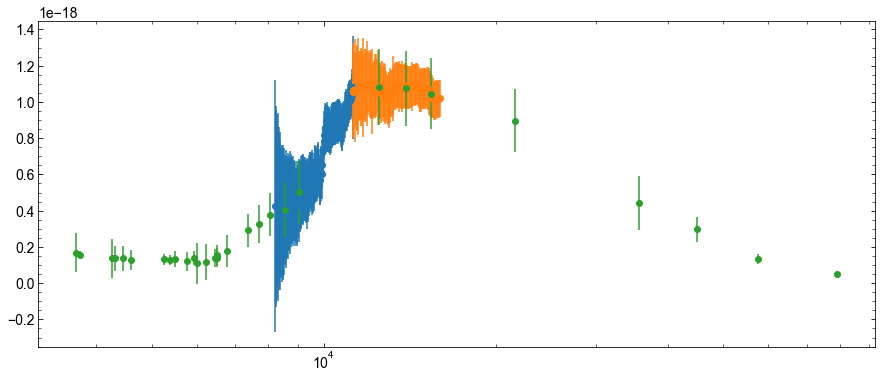

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=[15,6])
plt.errorbar(wvs[0], flxs[0], errs[0], linestyle = 'none', marker = 'o')
plt.errorbar(wvs[1], flxs[1], errs[1], linestyle = 'none', marker = 'o')
plt.errorbar(Gs.Pwv, Gs.Pflx, Gs.Perr, linestyle = 'none', marker = 'o')
plt.xscale('log')

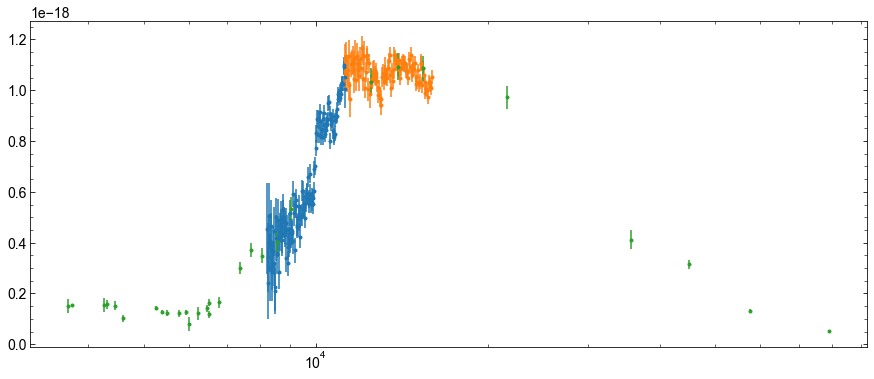

In [35]:
plt.figure(figsize=[15,6])
plt.errorbar(wvs[0], flxs[0], errs[0], linestyle = 'none', marker = 'o',ms = 3)
plt.errorbar(wvs[1], flxs[1], errs[1], linestyle = 'none', marker = 'o',ms = 3)
plt.errorbar(Gs.Pwv, Spmfl, Spmerr, linestyle = 'none', marker = 'o',ms = 3)
plt.xscale('log')

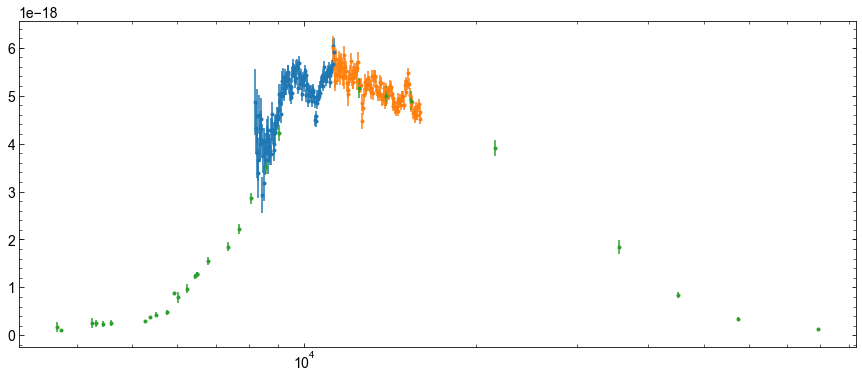

In [24]:
plt.figure(figsize=[15,6])
plt.errorbar(Gs.Bwv, Gs.Bfl, Gs.Ber, linestyle = 'none', marker = 'o',ms = 3)
plt.errorbar(Gs.Rwv, Gs.Rfl, Gs.Rer, linestyle = 'none', marker = 'o',ms = 3)
plt.errorbar(Gs.Pwv, Gs.Pflx, Gs.Perr, linestyle = 'none', marker = 'o',ms = 3)
plt.xscale('log')

In [131]:
IDX = []
for i in Sdb.query('zgrism == 1.5').index:
    if Sdb.sfr[i] < 1: 
        IDX.append(i)
        
NsSFR = []      
num = 0
idx=0
while num  < 40:
    try: 
        i = IDX[idx]

        lbt, sfh = np.load('../sim_SFH/SFH_z1.5_{}.npy'.format(Sdb.gid[i]),allow_pickle = True)
        lbt = lbt - min(lbt)
        
        Nsfh = np.zeros_like(sfh)
        nssfr = np.random.choice(np.linspace(-18, -14, 1000))

        for ii in range(len(lbt)):
            if lbt[ii] < 0.3:
                Nsfh[ii] = 10**nssfr * 10**Sdb.lmass[i]
            else:
                Nsfh[ii] = sfh[ii]
        idx += 1 
        num += 1
        np.save('../sim_SFH/SFH_z1.5_{}_LsSFR_{}'.format(Sdb.gid[i], num), [lbt, Nsfh],allow_pickle = True)
        sfr, ssfr = get_sSFR(lbt, Nsfh, lmass = Sdb.lmass[i])
        NsSFR.append(ssfr)
        
    except:
        idx = 0
        
np.save('../dataframes/galaxy_frames/LsSFR_sim_z1.5', NsSFR,allow_pickle = True)


In [135]:
LSdb = pd.read_pickle('../dataframes/fitdb/Ifit_LsSFR_imp_db.pkl')
z10lssfr = np.load('../dataframes/galaxy_frames/LsSFR_sim_z1.0.npy',allow_pickle = True)
z15lssfr = np.load('../dataframes/galaxy_frames/LsSFR_sim_z1.5.npy',allow_pickle = True)
z20lssfr = np.load('../dataframes/galaxy_frames/LsSFR_sim_z2.0.npy',allow_pickle = True)
Olssfr = np.append(z10lssfr, np.append(z15lssfr, z20lssfr))

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


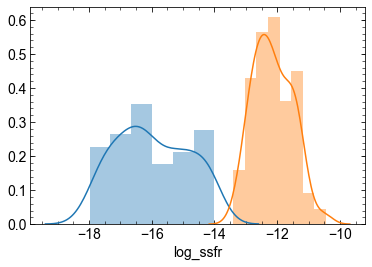

In [140]:
sea.distplot(Olssfr)
sea.distplot(LSdb.log_ssfr)

In [6]:

############
def Best_fit_scale(wv, fl, er, mfl, p1):
    cal = Calibrate_grism([wv, fl, er], mfl, p1)
    scale = Scale_model(fl / cal, er/ cal, mfl)
    FL =  fl/ cal/ scale
    ER =  er/ cal/ scale
    return FL, ER

def Q_spec_adjust(Gs, specz):
    sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)
    sp.params['dust2'] = fit_db['bfd']
    sp.params['dust1'] = fit_db['bfd']
    sp.params['logzsol'] = np.log10(fit_db['bfm'])
    
    time, sfr, tmax = convert_sfh(get_agebins(fit_db['bfa']), 
        [fit_db['bfm1'], fit_db['bfm2'], fit_db['bfm3'], 
         fit_db['bfm4'], fit_db['bfm5'], 
         fit_db['bfm6'],fit_db['bfm7'], fit_db['bfm8'], 
         fit_db['bfm9'], fit_db['bfm10']], maxage = fit_db['bfa']*1E9)

    sp.set_tabular_sfh(time,sfr) 

    wave, flux = sp.get_spectrum(tage = fit_db['bfa'], peraa = True)
    flam = F_lam_per_M(flux,wave*(1 + specz), specz, 0, sp.stellar_mass)*10**fit_db['bflm']
    
    return wave, flam, sp

def SF_spec_adjust(Gs, specz):
    sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 2)
    sp.params['dust1'] = 0
    sp.params['dust2'] = fit_db['bfd']
    sp.params['logzsol'] = np.log10(fit_db['bfm'])

    time, sfr, tmax = convert_sfh(get_agebins(fit_db['bfa'], binnum = 6), 
        [fit_db['bfm1'], fit_db['bfm2'], fit_db['bfm3'], fit_db['bfm4'], fit_db['bfm5'], 
         fit_db['bfm6']], maxage = fit_db['bfa']*1E9)

    sp.set_tabular_sfh(time,sfr) 

    wave, flux = sp.get_spectrum(tage = fit_db['bfa'], peraa = True)
    flam = F_lam_per_M(flux,wave*(1 + specz), specz, 0, sp.stellar_mass)*10**fit_db['bflm']
    
    return wave, flam, sp

In [7]:
fit_db['bfd']

0.3212450509171203

In [8]:
from spec_id import *
def spec_sim_werr(Gs,lbt,sfh, dust, metal, SFa, lm = 11, z = 1.5):
    wvs, flxs, errs, beams, trans = Gather_grism_data_from_2d(Gs, sp)
    sp.set_tabular_sfh(lbt, sfh[::-1])
    sp.params['dust2'] = dust
    
    if SFa == 'Q':
        sp.params['dust1'] = dust
    else:
        sp.params['dust1'] = 0
        
    sp.params['logzsol'] = np.log10(metal)

    wave, flux = sp.get_spectrum(tage = lbt[-1], peraa = True)
    flam = F_lam_per_M(flux,wave*(1+z),z,0,10**lm)*10**lm

    Smfl, Pmfl = Full_forward_model(Gs, wave,flam, z, 
                                    wvs, flxs, errs, beams, trans)
    
    Sc =  Scale_model(Gs.Pflx, Gs.Perr, Pmfl)
    
    for i in range(len(Smfl)):
        Smfl[i] = Smfl[i] + np.random.normal(0,errs[i])/Sc
        Pmfl[i] = Pmfl[i] + np.random.normal(0,Gs.Perr[i])/Sc
    
    return wvs, Smfl, errs/Sc, beams, trans, Pmfl, Gs.Perr/Sc

In [4]:
import make_sfh_tool
from importlib import reload
reload(make_sfh_tool)
from spec_tools import Highest_density_region

In [16]:
Gid = 23
zspec = 2.0
gid = Sdb.query('zgrism == {} and gid == {}'.format(zspec, Gid)).index.values[0]
SFH_dist = make_sfh_tool.Gen_sim_SFH('z{}_{}_Ifit_impfits.npy'.format(zspec, Gid), 5000, zspec) 
lbt, sfh = np.load('../sim_SFH/SFH_z{}_{}.npy'.format(zspec,Gid),allow_pickle = True)
sfh = sfh[1:]
lbt = lbt[:-1]
fit_db = np.load('../data/posteriors/z{}_{}_Ifit_impfits.npy'.format(zspec, Gid), allow_pickle = True).item()

if Sdb.SFa[gid] == 'Q':
    sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)
    Gs = Gen_spec_2D('GND', 21156, zspec, g102_lims=[8200, 11300], g141_lims=[11200, 16000],
                     phot_errterm = 0.04, irac_err = 0.08, mask = False)
else:
    sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 2)
    if zspec == 1.0:
        #maybe 16041
        Gs = Gen_spec_2D('GND',37006, 1.0, g102_lims=[8200, 11300], g141_lims=[11200, 16000],
             phot_errterm = 0.04, irac_err = 0.08, mask = True)
    if zspec == 1.5:
        Gs = Gen_spec_2D('GND',27930, 1.5, g102_lims=[8200, 11300], g141_lims=[11200, 16000],
                     phot_errterm = 0.04, irac_err = 0.08, mask = True)
    if zspec == 2.0:
        Gs = Gen_spec_2D('GND', 19591, 2.0, g102_lims=[8200, 11300], g141_lims=[11200, 16000],
             phot_errterm = 0.04, irac_err = 0.08, mask = True)     

load_master_fits: /Volumes/Vince_CLEAR/RELEASE_v2.1.0/BEAMS/GN4/GN4_21156.beams.fits


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-1.0.dev1443-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3596: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


1 icat25hcq_flt.fits G102
2 icat25hiq_flt.fits G102
3 icat25icq_flt.fits G102
4 icat25iiq_flt.fits G102
5 ib3725dyq_flt.fits G141
6 ib3725e2q_flt.fits G141
7 ib3725eeq_flt.fits G141
8 ib3725eiq_flt.fits G141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-1.0.dev1443-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1585: RuntimeWarning: divide by zero encountered in true_divide
  ivar = 1./(1/b.ivar + (self.sys_err*sciu)**2)


load_master_fits: /Volumes/Vince_CLEAR/RELEASE_v2.1.0/BEAMS/GN2/GN2_21156.beams.fits
1 icat21cfq_flt.fits G102
2 icat21coq_flt.fits G102
3 icat21dgq_flt.fits G102
4 icat21dlq_flt.fits G102
5 icxt55krq_flt.fits G102
6 icxt55ksq_flt.fits G102
7 icxt55kvq_flt.fits G102
8 icxt55kxq_flt.fits G102
9 icxta4mdq_flt.fits G102
10 icxta4meq_flt.fits G102
11 icxta4mhq_flt.fits G102
12 icxta4mjq_flt.fits G102
13 icxt52i0q_flt.fits G102
14 icxt52i1q_flt.fits G102
15 icxt52i4q_flt.fits G102
16 icxt52i6q_flt.fits G102
17 icxt53i9q_flt.fits G102
18 icxt53iaq_flt.fits G102
19 icxt53idq_flt.fits G102
20 icxt53ifq_flt.fits G102
21 icxt51jvq_flt.fits G102
22 icxt51jwq_flt.fits G102
23 icxt51jzq_flt.fits G102
24 icxt51k1q_flt.fits G102
25 ib3721xiq_flt.fits G141
26 ib3721xmq_flt.fits G141
27 ib3721xyq_flt.fits G141
28 ib3721y2q_flt.fits G141


/Users/Vince.ec/GitHub/Cluster_and_field/scripts/spec_exam.py:786: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bm.grism.parent_file in BMX:
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-1.0.dev1443-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:590: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


False
advanced
False
advanced


In [17]:
wvs, flxs, errs, beams, trans, Spmfl, Spmerr = spec_sim_werr(Gs, lbt, sfh, Sdb.Av[gid], Sdb.Z[gid], Sdb.SFa[gid], lm = Sdb.lmass[gid], z=zspec)
Gs.Pflx = Spmfl
Gs.Perr = Spmerr

######## Q-method
if Sdb.SFa[gid] == 'Q':
    wave, flam, sp = Q_spec_adjust(Gs, zspec)

######## SF-method
else:
    wave, flam, sp = SF_spec_adjust(Gs, zspec)
    
Gmfl, Pmfl = Full_forward_model(Gs, wave,flam, zspec, wvs, flxs, errs, beams, trans)

BFL, BER = Best_fit_scale(wvs[0], flxs[0], errs[0], Gmfl[0],  fit_db['bfbp1'])
RFL, RER = Best_fit_scale(wvs[1], flxs[1], errs[1], Gmfl[1],  fit_db['bfrp1'])


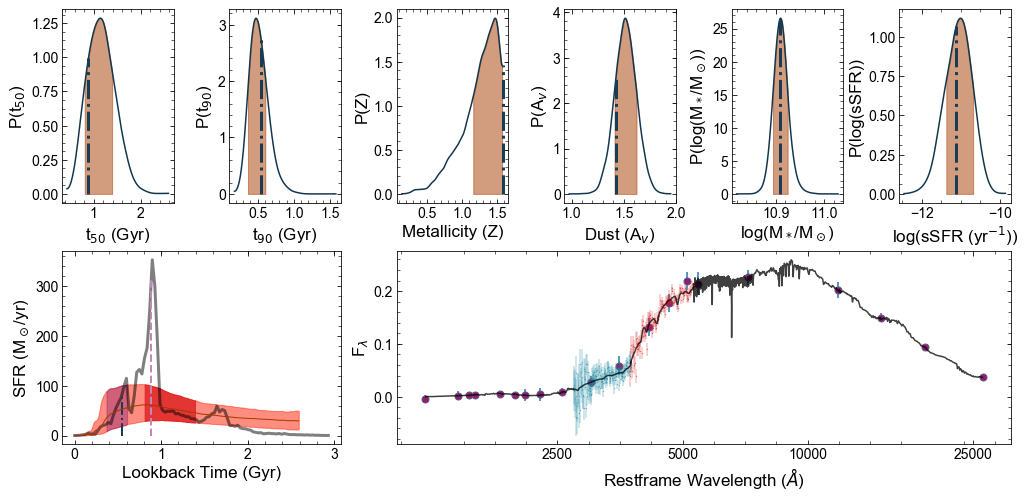

In [23]:
gs = gridspec.GridSpec(2,6, wspace=0.5, hspace=0.25)

plt.figure(figsize=[17,8])
ax1=plt.subplot(gs[0]);ax2=plt.subplot(gs[1]);ax3=plt.subplot(gs[2]);ax4=plt.subplot(gs[6:8])
ax5=plt.subplot(gs[3]);ax6=plt.subplot(gs[4]);ax7=plt.subplot(gs[5]);ax8=plt.subplot(gs[8:12])

    
####ax1####

ax1.plot(SFH_dist.t50, SFH_dist.Pt50, color = '#11364d')
idist = interp1d(SFH_dist.t50, SFH_dist.Pt50)
ax1.plot([Sdb.t50[gid],Sdb.t50[gid]], [0,idist(Sdb.t50[gid])], '-.', color = '#173c53', linewidth = 3)
ax1.fill_between(np.linspace(Mdb.t_50_hdr[gid][0], Mdb.t_50_hdr[gid][1], 1000), 
    idist(np.linspace(Mdb.t_50_hdr[gid][0], Mdb.t_50_hdr[gid][1], 1000)), color = '#a73b00', alpha = 0.5)
####ax2####
ax2.plot(SFH_dist.t90, SFH_dist.Pt90, color = '#11364d')
idist = interp1d(SFH_dist.t90, SFH_dist.Pt90)
ax2.plot([Sdb.t90[gid],Sdb.t90[gid]], [0,idist(Sdb.t90[gid])], '-.', color = '#173c53', linewidth = 3)
ax2.fill_between(np.linspace(Mdb.t_90_hdr[gid][0], Mdb.t_90_hdr[gid][1], 1000), 
    idist(np.linspace(Mdb.t_90_hdr[gid][0], Mdb.t_90_hdr[gid][1], 1000)), color = '#a73b00', alpha = 0.5)
####ax3####
ax3.plot(fit_db['m'],fit_db['Pm'], color = '#11364d')
idist = interp1d(fit_db['m'],fit_db['Pm'], bounds_error=False, fill_value=fit_db['Pm'][-1])
ax3.plot([Sdb.Z[gid],Sdb.Z[gid]], [0,idist(Sdb.Z[gid])], '-.', color = '#173c53', linewidth = 3)
ax3.fill_between(np.linspace(Mdb.Z_hdr[gid][0], Mdb.Z_hdr[gid][1], 1000), 
    idist(np.linspace(Mdb.Z_hdr[gid][0], Mdb.Z_hdr[gid][1], 1000)), color = '#a73b00', alpha = 0.5)
####ax4####

LBT,SFH = np.load('../data/SFH/z{}_{}_imp.npy'.format(zspec,Gid))
LBT,SFH16 = np.load('../data/SFH/z{}_{}_imp_16.npy'.format(zspec,Gid))
LBT,SFH84 = np.load('../data/SFH/z{}_{}_imp_84.npy'.format(zspec,Gid))

lbt, sfh = np.load('../sim_SFH/SFH_z{}_{}.npy'.format(zspec,Gid),allow_pickle = True)
lbt = lbt - min(lbt)
isfh  = interp1d(lbt, sfh)

ax4.plot(lbt, sfh, 'k', linewidth = 3, alpha = 0.5)
ax4.plot([Sdb.t50[gid],Sdb.t50[gid]], [0,isfh(Sdb.t50[gid])], '--', color = '#c586b8', linewidth = 2)
ax4.plot([Sdb.t90[gid],Sdb.t90[gid]], [0,isfh(Sdb.t90[gid])], '-.', color = '#173c53', linewidth = 2)
ax4.plot(LBT, SFH, "#a43900", linewidth = 1)
ax4.fill_between(LBT, SFH16,  SFH84 , color = '#ff1d00', alpha = 0.5)
    
iSFH16  = interp1d(LBT, SFH16)
iSFH84  = interp1d(LBT, SFH84)

t50_range  = np.linspace(Mdb.t_50_hdr[gid][0],Mdb.t_50_hdr[gid][1], 100)
t90_range  = np.linspace(Mdb.t_90_hdr[gid][0],Mdb.t_90_hdr[gid][1], 100)

ax4.fill_between(t50_range, iSFH16(t50_range), iSFH84(t50_range), alpha = 0.8, color = '#dc1f22')
ax4.fill_between(t90_range, iSFH16(t90_range), iSFH84(t90_range), alpha = 0.4, color = '#8a1c70')

####ax5####
ax5.plot(fit_db['d'],fit_db['Pd'], color='#11364d')
idist = interp1d(fit_db['d'],fit_db['Pd'])
ax5.plot([Sdb.Av[gid],Sdb.Av[gid]], [0,idist(Sdb.Av[gid])], '-.', color = '#173c53', linewidth = 3)
ax5.fill_between(np.linspace(Mdb.Av_hdr[gid][0], Mdb.Av_hdr[gid][1], 1000), 
    idist(np.linspace(Mdb.Av_hdr[gid][0], Mdb.Av_hdr[gid][1], 1000)), color='#a73b00', alpha = 0.5)
####ax6####
ax6.plot(fit_db['lm'],fit_db['Plm'], color='#11364d')
idist = interp1d(fit_db['lm'],fit_db['Plm'])
ax6.plot([Sdb.lmass[gid],Sdb.lmass[gid]], [0,idist(Sdb.lmass[gid])], '-.', color = '#173c53', linewidth = 3)
ax6.fill_between(np.linspace(Mdb.lmass_hdr[gid][0], Mdb.lmass_hdr[gid][1], 1000), 
    idist(np.linspace(Mdb.lmass_hdr[gid][0], Mdb.lmass_hdr[gid][1], 1000)), color='#a73b00', alpha = 0.5)
####ax7####
ax7.plot(SFH_dist.ssfr, SFH_dist.Pssfr, color='#11364d')
idist = interp1d(SFH_dist.ssfr, SFH_dist.Pssfr)
ax7.plot([Sdb.sSFR[gid],Sdb.sSFR[gid]], [0,idist(Sdb.sSFR[gid])], '-.', color = '#173c53', linewidth = 3)
ax7.fill_between(np.linspace(Mdb.log_ssfr_hdr[gid][0], Mdb.log_ssfr_hdr[gid][1], 1000), 
    idist(np.linspace(Mdb.log_ssfr_hdr[gid][0], Mdb.log_ssfr_hdr[gid][1], 1000)), color='#a73b00', alpha = 0.5)
####ax8####
ax8.errorbar(np.log10(Gs.Bwv_rf),BFL*1E18, BER*1E18,
            linestyle='None', marker='o', markersize=0.25, color='#1f8ba3', zorder = 2, elinewidth = 0.4, alpha = 1)
ax8.plot(np.log10(Gs.Bwv_rf),Gmfl[0] *1E18,'k', zorder = 4, alpha = 0.75)

ax8.errorbar(np.log10(Gs.Rwv_rf),RFL*1E18, RER*1E18,
        linestyle='None', marker='o', markersize=0.25, color='#dc1f22', zorder = 2, elinewidth = 0.4, alpha = 1)
ax8.plot(np.log10(Gs.Rwv_rf),Gmfl[1] *1E18,'k', zorder = 4, alpha = 0.75)


ax8.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
        linestyle='None', marker='o', markersize=7, markerfacecolor='#8a1e72', zorder = 1,
             markeredgecolor = '#685877',markeredgewidth = 1)
IDB = [U for U in range(len(wave)) if min(Gs.Pwv/(1+zspec)) < wave[U] < min(wvs[0]/(1+zspec))]
IDR = [U for U in range(len(wave)) if max(wvs[1]/(1+zspec)) < wave[U] < max(Gs.Pwv/(1+zspec))]
ax8.plot(np.log10(wave)[IDB],flam[IDB]*1E18,'k', alpha = 0.75, zorder=5)
ax8.plot(np.log10(wave)[IDR],flam[IDR]*1E18,'k', alpha = 0.75)

ax8.set_xticks(np.log10([2500,5000,10000,25000]))
ax8.set_xticklabels(np.array([2500,5000,10000,25000]))
###########
ax1.set_xlabel('t$_{50}$ (Gyr)', fontsize=17)
ax1.set_ylabel('P(t$_{50}$)', fontsize=17)
ax1.tick_params(axis='both', which='major', labelsize=14)

ax2.set_xlabel('t$_{90}$ (Gyr)', fontsize=17)
ax2.set_ylabel('P(t$_{90}$)', fontsize=17)
ax2.tick_params(axis='both', which='major', labelsize=14)

ax3.set_xlabel('Metallicity (Z)', fontsize=17)
ax3.set_ylabel('P(Z)', fontsize=17)
ax3.tick_params(axis='both', which='major', labelsize=14)

ax4.set_xlabel('Lookback Time (Gyr)', fontsize=17)
ax4.set_ylabel('SFR (M$_\odot$/yr)', fontsize=17)
ax4.tick_params(axis='both', which='major', labelsize=14)

ax5.set_xlabel('Dust (A$_v$)', fontsize=17)
ax5.set_ylabel('P(A$_v$)', fontsize=17)
ax5.tick_params(axis='both', which='major', labelsize=14)

ax6.set_xlabel('log(M$_*$/M$_\odot$)', fontsize=17)
ax6.set_ylabel('P(log(M$_*$/M$_\odot$))', fontsize=17)
ax6.tick_params(axis='both', which='major', labelsize=14)

ax7.set_xlabel('log(sSFR (yr$^{-1}$))', fontsize=17)
ax7.set_ylabel('P(log(sSFR))', fontsize=17)
ax7.tick_params(axis='both', which='major', labelsize=14)

ax8.set_xlabel(r'Restframe Wavelength ($\AA$)', fontsize=17)
ax8.set_ylabel('F$_\lambda$', fontsize=17)
ax8.tick_params(axis='both', which='major', labelsize=14)
plt.savefig('../plots/evolution_plots/sample_fit_z{}_{}.pdf'.format(zspec, Gid), bbox_inches = 'tight')    

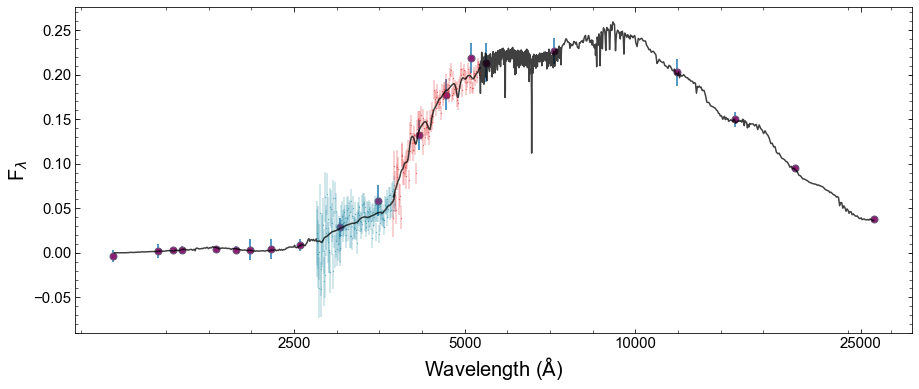

In [19]:
plt.figure(figsize = [15,6])

plt.errorbar(np.log10(Gs.Bwv_rf),BFL*1E18, BER*1E18,
            linestyle='None', marker='o', markersize=0.25, color='#1f8ba3', zorder = 2, elinewidth = 0.4, alpha = 1)
plt.plot(np.log10(Gs.Bwv_rf),Gmfl[0] *1E18,'k', zorder = 4, alpha = 0.75)

plt.errorbar(np.log10(Gs.Rwv_rf),RFL*1E18, RER*1E18,
        linestyle='None', marker='o', markersize=0.25, color='#dc1f22', zorder = 2, elinewidth = 0.4, alpha = 1)
plt.plot(np.log10(Gs.Rwv_rf),Gmfl[1] *1E18,'k', zorder = 4, alpha = 0.75)


plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
        linestyle='None', marker='o', markersize=7, markerfacecolor='#8a1e72', zorder = 1,
             markeredgecolor = '#685877',markeredgewidth = 1)
IDB = [U for U in range(len(wave)) if min(Gs.Pwv/(1+zspec)) < wave[U] < min(wvs[0]/(1+zspec))]
IDR = [U for U in range(len(wave)) if max(wvs[1]/(1+zspec)) < wave[U] < max(Gs.Pwv/(1+zspec))]
plt.plot(np.log10(wave)[IDB],flam[IDB]*1E18,'k', alpha = 0.75, zorder=5)
plt.plot(np.log10(wave)[IDR],flam[IDR]*1E18,'k', alpha = 0.75)

plt.xticks(np.log10([2500,5000,10000,25000]),np.array([2500,5000,10000,25000]))
plt.xlabel(r'Wavelength ($\rm \AA$)', fontsize=20)
plt.ylabel(r'F$_\lambda$', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)

In [21]:
Sdb.Z[gid],fit_db['m']

(1.593710212075391,
 array([0.13544524, 0.13833506, 0.14122488, 0.1441147 , 0.14700452,
        0.14989433, 0.15278415, 0.15567397, 0.15856379, 0.16145361,
        0.16434343, 0.16723324, 0.17012306, 0.17301288, 0.1759027 ,
        0.17879252, 0.18168233, 0.18457215, 0.18746197, 0.19035179,
        0.19324161, 0.19613143, 0.19902124, 0.20191106, 0.20480088,
        0.2076907 , 0.21058052, 0.21347034, 0.21636015, 0.21924997,
        0.22213979, 0.22502961, 0.22791943, 0.23080924, 0.23369906,
        0.23658888, 0.2394787 , 0.24236852, 0.24525834, 0.24814815,
        0.25103797, 0.25392779, 0.25681761, 0.25970743, 0.26259725,
        0.26548706, 0.26837688, 0.2712667 , 0.27415652, 0.27704634,
        0.27993615, 0.28282597, 0.28571579, 0.28860561, 0.29149543,
        0.29438525, 0.29727506, 0.30016488, 0.3030547 , 0.30594452,
        0.30883434, 0.31172416, 0.31461397, 0.31750379, 0.32039361,
        0.32328343, 0.32617325, 0.32906306, 0.33195288, 0.3348427 ,
        0.33773252, 0.340622

IndexError: index 0 is out of bounds for axis 0 with size 0

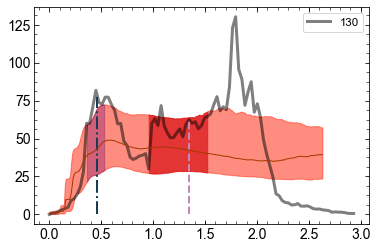

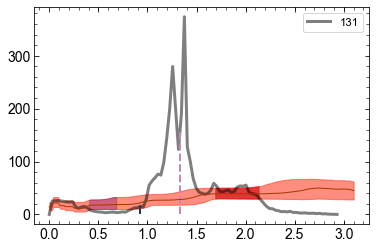

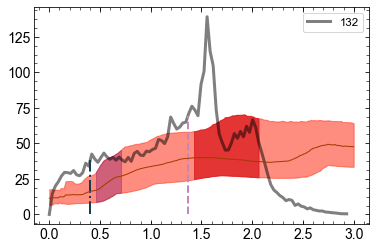

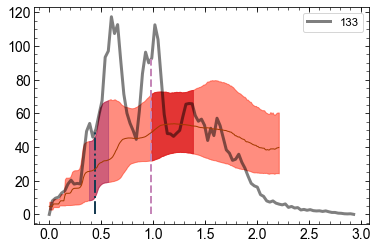

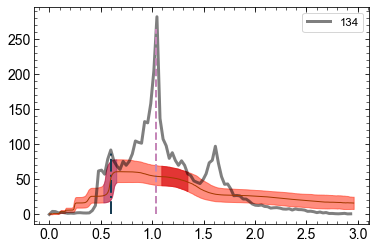

In [223]:
####ax4####
Gid = 130
zspec = 2.0

for i in range(10):
    
    gid = Sdb.query('zgrism == {} and gid == {}'.format(zspec, Gid + i)).index.values[0]
    plt.figure()
    LBT,SFH = np.load('../data/SFH/z{}_{}_imp.npy'.format(zspec,Gid+i))
    LBT,SFH16 = np.load('../data/SFH/z{}_{}_imp_16.npy'.format(zspec,Gid+i))
    LBT,SFH84 = np.load('../data/SFH/z{}_{}_imp_84.npy'.format(zspec,Gid+i))

    lbt, sfh = np.load('../sim_SFH/SFH_z{}_{}.npy'.format(zspec,Gid+i),allow_pickle = True)
    lbt = lbt - min(lbt)
    isfh  = interp1d(lbt, sfh)

    plt.plot(lbt, sfh, 'k', linewidth = 3, alpha = 0.5, label = Gid + i)
    plt.plot([Sdb.t50[gid],Sdb.t50[gid]], [0,isfh(Sdb.t50[gid])], '--', color = '#c586b8', linewidth = 2)
    plt.plot([Sdb.t90[gid],Sdb.t90[gid]], [0,isfh(Sdb.t90[gid])], '-.', color = '#173c53', linewidth = 2)
    plt.plot(LBT, SFH, "#a43900", linewidth = 1)
    plt.fill_between(LBT, SFH16,  SFH84 , color = '#ff1d00', alpha = 0.5)
    plt.legend()
    iSFH16  = interp1d(LBT, SFH16)
    iSFH84  = interp1d(LBT, SFH84)

    t50_range  = np.linspace(Mdb.t_50_hdr[gid][0],Mdb.t_50_hdr[gid][1], 100)
    t90_range  = np.linspace(Mdb.t_90_hdr[gid][0],Mdb.t_90_hdr[gid][1], 100)

    plt.fill_between(t50_range, iSFH16(t50_range), iSFH84(t50_range), alpha = 0.8, color = '#dc1f22')
    plt.fill_between(t90_range, iSFH16(t90_range), iSFH84(t90_range), alpha = 0.4, color = '#8a1c70')

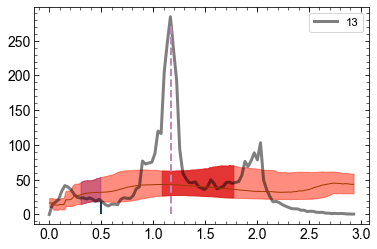

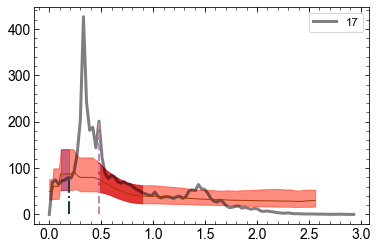

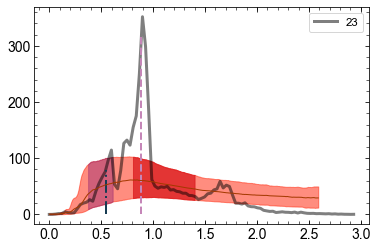

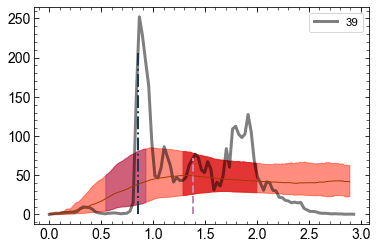

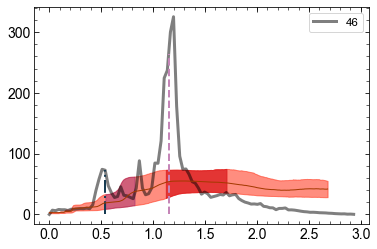

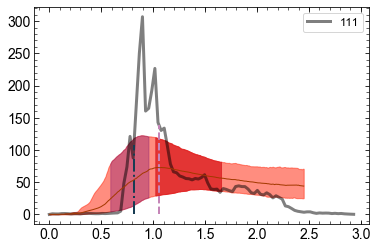

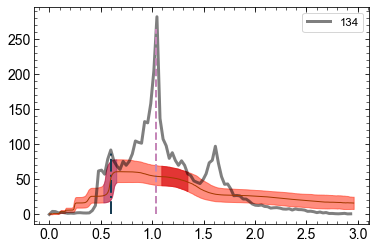

In [224]:
####ax4####
zspec = 2.0

for Gid in [13,17,23,39,46,111,134]:
    
    gid = Sdb.query('zgrism == {} and gid == {}'.format(zspec, Gid)).index.values[0]
    plt.figure()
    LBT,SFH = np.load('../data/SFH/z{}_{}_imp.npy'.format(zspec,Gid))
    LBT,SFH16 = np.load('../data/SFH/z{}_{}_imp_16.npy'.format(zspec,Gid))
    LBT,SFH84 = np.load('../data/SFH/z{}_{}_imp_84.npy'.format(zspec,Gid))

    lbt, sfh = np.load('../sim_SFH/SFH_z{}_{}.npy'.format(zspec,Gid),allow_pickle = True)
    lbt = lbt - min(lbt)
    isfh  = interp1d(lbt, sfh)

    plt.plot(lbt, sfh, 'k', linewidth = 3, alpha = 0.5, label = Gid)
    plt.plot([Sdb.t50[gid],Sdb.t50[gid]], [0,isfh(Sdb.t50[gid])], '--', color = '#c586b8', linewidth = 2)
    plt.plot([Sdb.t90[gid],Sdb.t90[gid]], [0,isfh(Sdb.t90[gid])], '-.', color = '#173c53', linewidth = 2)
    plt.plot(LBT, SFH, "#a43900", linewidth = 1)
    plt.fill_between(LBT, SFH16,  SFH84 , color = '#ff1d00', alpha = 0.5)
    plt.legend()
    iSFH16  = interp1d(LBT, SFH16)
    iSFH84  = interp1d(LBT, SFH84)

    t50_range  = np.linspace(Mdb.t_50_hdr[gid][0],Mdb.t_50_hdr[gid][1], 100)
    t90_range  = np.linspace(Mdb.t_90_hdr[gid][0],Mdb.t_90_hdr[gid][1], 100)

    plt.fill_between(t50_range, iSFH16(t50_range), iSFH84(t50_range), alpha = 0.8, color = '#dc1f22')
    plt.fill_between(t90_range, iSFH16(t90_range), iSFH84(t90_range), alpha = 0.4, color = '#8a1c70')